<a href="https://colab.research.google.com/github/kanishquetyagi/Company-Bankruptcy-Prediction/blob/main/COMPANY_BANKRUPTCY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import pandas as pd
import numpy as np
#df=pd.read_csv('/content/drive/MyDrive/COMPANY BANKRUPTCY PREDICTION.csv')
df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4 - ML/Week 1/Datasets/COMPANY BANKRUPTCY PREDICTION.csv')

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.display.float_format = '{:,.6f}'.format
from imblearn.ensemble import BalancedBaggingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# BANKRUPTCY PREDICTION

##Initial EDA

In [96]:
df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.000000,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,"4,980,000,000.000000",0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,"701,000,000.000000","6,550,000,000.000000",0.593831,"458,000,000.000000",0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.000000,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,"6,110,000,000.000000",0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,0.000107,"7,700,000,000.000000",0.593916,"2,490,000,000.000000",0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.000236,"25,500,000.000000",0.458521,0.000790,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,"7,280,000,000.000000",0.0003

In [97]:
df.shape

(6819, 96)

**Dataset is consist of 6819 rows and 96 features including the dependent variable**

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [99]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000",...,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000"
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,"1,995,347,312.802792","1,950,427,306.056799",0.467431,"16,448,012.905942",0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,"1,328,640.602096",0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,"5,508,096,595.248731","1,566,212.055241",0.264248,0.379677,"403,284.954245","8,376,594.819685",0.630991,"4,416,336.714259",0.113177,0.886823,0.008783,...,0.522273,0.124095,"3,592,902.196830","37,159,994.147133",0.090673,0.353828,0.277395,"55,806,804.525780",0.761599,0.73581

<h2> Checking for Missing Values

In [100]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [101]:
df.isnull().sum().sum()

0

**There are no missing values in our dataset i.e 0 Non-Null value**

In [102]:
df.duplicated().sum()

0

**There are no duplicated values in the dataset as well.**

## <h2>Checking for Categorical features with less than equal to 10 categories.

In [103]:
#creating a for loop to get the categorical columns with 10 or less than 10 unique values
list_1=[]
for i in df.columns:
  x=df[i].value_counts()
  if len(x)<=15:
    list_1.append(i)
  else:
    continue
list_1

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

**We've found only 2 categorical features.**

In [104]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

**Liability-Assets Flag consist of 2 unique values with high imabalance**

In [105]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

**Net Income Flag consist of only 1 unique values. Hence, we're dropping both categorical features.**

In [106]:
df.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'],inplace=True)

In [107]:
df.shape

(6819, 94)

# <h2> Base-Model Building

In [108]:
X = df.drop('Bankrupt?', axis=1)
Y = df['Bankrupt?']


In [109]:
X.shape

(6819, 93)

In [110]:
Y.shape

(6819,)

In [111]:
# *Train and Test Split of the Dataset:-*

from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(X,Y,test_size=0.20, random_state=0, stratify=Y)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# x_train_norm = scaler.fit_transform(x_train)
x_train_norm = scaler.fit_transform(train_X)
x_test_norm = scaler.transform(test_X)


In [112]:
x_train_norm.shape

(5455, 93)

In [113]:
#creating a dataframe consisting of different metrics along with the Algorithms used.
metric_report = pd.DataFrame(columns = ['logistic_regression','random_forest','SVM','gaussian_naive_bayes','KNN','XGBOOST'], index = ['test_acc','train_acc','test_precision','train_precision','test_recall','train_recall','test_f1-score','train_f1-score','test_auc','train_auc'])

In [114]:
#Generating Evaluation Matrix
def metricCalc(y_acc_test,y_acc_train,y_predicts_test,y_predicts_train,classifier_name,y_test_prob ,y_train_prob):

  train_accuracy = accuracy_score(y_acc_train,y_predicts_train)
  test_accuracy = accuracy_score(y_acc_test,y_predicts_test)

  train_cm = confusion_matrix(y_acc_train,y_predicts_train)
  test_cm = confusion_matrix(y_acc_test,y_predicts_test )

  prec_train = train_cm[1][1]/(train_cm[1][1] + train_cm[0][1])
  prec_test = test_cm[1][1]/(test_cm[1][1] + test_cm[0][1])

  recall_train = train_cm[1][1]/(train_cm[1][0] + train_cm[1][1])
  recall_test = test_cm[1][1]/(test_cm[1][0] + test_cm[1][1])

  f1_train = (2*prec_train*recall_train)/(recall_train + prec_train)
  f1_test = (2*prec_test*recall_test)/(recall_test + prec_test)

  auc_train = roc_auc_score(y_acc_train,y_train_prob)
  auc_test = roc_auc_score(y_acc_test,y_test_prob)

  eval_list = [test_accuracy,train_accuracy,prec_test,prec_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train]
  
  metric_report[classifier_name] = eval_list

In [115]:
# function that stores all the hyperparameters along with cross validation.
def modelGridSearchParams():

  # a dict that stores the params of the best models
  best_models = {}

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # grid search for Logistic Regression
  model = LogisticRegression(class_weight='balanced',C=0.01)
  solvers = ['lbfgs']
  penalty = ['l2']
  c_values = [100, 10, 1.0, 0.1, 0.01]

  grid = dict(solver = solvers,penalty=penalty,C=c_values)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
  grid_result = grid_search.fit(x_train_norm, train_y)

  best_models['lr_model'] = grid_result.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # Random Forest

  # Number of trees
  n_estimators = [100,250]
  # Maximum depth of trees
  max_depth = [4,6,8]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}

  rf_model = RandomForestClassifier(class_weight='balanced')

  # Grid search
  rf_grid = GridSearchCV(estimator=rf_model,
                        param_grid = param_dict,
                        cv = 5, verbose=2, scoring='roc_auc')

  rf_grid.fit(x_train_norm,train_y)

  best_models['rf_model'] = rf_grid.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # SVM
  svm_clf = SVC(probability=True, kernel='linear',class_weight='balanced')
  svm_clf.fit(x_train_norm,train_y)
  parameters = {'C':np.linspace(0.1,0.01,1), 'gamma':('scale','auto')}
  clf_grid = GridSearchCV(estimator = svm_clf, param_grid = parameters)
  #till here
  best_models['svm_model'] = clf_grid

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # XGBoost
  # Number of trees
  n_estimators = [50,80,100,250]
  # Maximum depth of trees
  max_depth = [4,6,8,12]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}
  clf_xgb = XGBClassifier(scale_pos_weight=102)

# random search
  xg_grid = RandomizedSearchCV(clf_xgb,param_dict,cv = 5, verbose=2, scoring='roc_auc')
  xg_grid.fit(x_train_norm,train_y)

  best_models['xgb_model'] = xg_grid.best_estimator_

  return best_models

In [116]:
# function that calculate the model results and stores in metric report.
def model_result(train_X,test_X,train_y,test_y):

  # get the best models after grid search
  best_models = modelGridSearchParams()

  # |||----------------------------------------------------------------------------------------------------------------------||| #

  # Logistic Regression:

  lr_class_train_pred = best_models['lr_model'].predict(train_X)
  lr_class_test_pred = best_models['lr_model'].predict(test_X)

  lr_prob_train_pred = best_models['lr_model'].predict_proba(train_X)[:,1]
  lr_prob_test_pred = best_models['lr_model'].predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Random Forest

  rf_class_train_pred = best_models['rf_model'].predict(train_X)
  rf_class_test_pred = best_models['rf_model'].predict(test_X)

  rf_prob_train_pred = best_models['rf_model'].predict_proba(train_X)[:,1]
  rf_prob_test_pred = best_models['rf_model'].predict_proba(test_X)[:,1]

# |||----------------------------------------------------------------------------------------------------------------------||| #

  # SVM
  svm_clf = best_models['svm_model'].fit(train_X,train_y)

  svm_class_train_pred = svm_clf.predict(train_X)
  svm_class_test_pred = svm_clf.predict(test_X)

  svm_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  svm_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Naive Bayes
  nbc = GaussianNB().fit(train_X, train_y)
  nbc_class_train_pred = nbc.predict(train_X)
  nbc_class_test_pred = nbc.predict(test_X)
  nbc_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  nbc_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # KNN
  knn = KNeighborsClassifier(n_neighbors=2,weights='uniform').fit(train_X,train_y)
  knn_class_train_pred = knn.predict(train_X)
  knn_class_test_pred = knn.predict(test_X)

  knn_prob_train_pred = knn.predict_proba(train_X)[:,1]
  knn_prob_test_pred = knn.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

# XGB
  xg_class_train_pred = best_models['xgb_model'].predict(train_X)
  xg_class_test_pred =  best_models['xgb_model'].predict(test_X)

  xg_prob_train_pred =  best_models['xgb_model'].predict_proba(train_X)[:,1]
  xg_prob_test_pred =  best_models['xgb_model'].predict_proba(test_X)[:,1]


# Calculating the scores of all the models
  metricCalc(test_y,train_y,lr_class_test_pred,lr_class_train_pred,'logistic_regression',lr_prob_test_pred,lr_prob_train_pred)
  metricCalc(test_y,train_y,rf_class_test_pred,rf_class_train_pred,'random_forest',rf_prob_test_pred,rf_prob_train_pred)
  metricCalc(test_y,train_y,svm_class_test_pred,svm_class_train_pred,'SVM',svm_prob_test_pred,svm_prob_train_pred)
  metricCalc(test_y,train_y,nbc_class_test_pred,nbc_class_train_pred,'gaussian_naive_bayes',nbc_prob_test_pred,nbc_prob_train_pred)
  metricCalc(test_y,train_y,knn_class_test_pred,knn_class_train_pred,'KNN',knn_prob_test_pred,knn_prob_train_pred)
  metricCalc(test_y,train_y,xg_class_test_pred,xg_class_train_pred,'XGBOOST',xg_prob_test_pred,xg_prob_train_pred)

  # report
  return metric_report

In [117]:
x_train_norm = scaler.fit_transform(train_X)
x_test_norm = scaler.transform(test_X)

In [118]:
model_result(x_train_norm,x_test_norm,train_y,test_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   1.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   2.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   2.7s
[CV] max_depth=4, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  6.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4, total=   3.0s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=50, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=40, max_depth=4 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=40, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=40, max_depth=4 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=40, max_depth=4, total=   2.9s
[CV] n_estimators=100, min_samples_split=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


,logistic_regression,random_forest,SVM,gaussian_naive_bayes,KNN,XGBOOST
test_acc,0.872434,0.907625,0.864370,0.316716,0.967742,0.964809
train_acc,0.880110,0.923556,0.878460,0.338955,0.975069,1.000000
test_precision,0.171717,0.215278,0.165877,0.042268,0.500000,0.444444
train_precision,0.198992,0.281307,0.198265,0.045816,1.000000,1.000000
test_recall,0.772727,0.704545,0.795455,0.931818,0.090909,0.363636
train_recall,0.897727,0.880682,0.909091,0.982955,0.227273,1.000000
test_f1-score,0.280992,0.329787,0.274510,0.080868,0.153846,0.400000
train_f1-score,0.325773,0.426410,0.325534,0.087551,0.370370,1.000000
test_auc,0.909220,0.938378,0.906723,0.906723,0.662328,0.927256
train_auc,0.956960,0.973803,0.953105,0.953105,0.991583,1.000000


## <h2> Handling Outliers

In [119]:
#taking out all the columns except dependent variable.
columns = df.columns[1:].tolist()

In [120]:
# df1 = df.iloc[:,1:].copy()
# X = df1
# Y = df['Bankrupt?']

In [121]:
# #X.columns.tolist()
# Y.value_counts()

In [122]:
# Removing Outliers.

# Q3 = X.quantile(0.75)
# Q1 = X.quantile(0.25)
# IQR = Q3 - Q1
# X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

In [123]:
# df['Bankrupt?'].value_counts()

Tried Removing Outlier but won't work in this case due to huge no of features.

## <h2>Capping Outliers

In [124]:
# capping the outliers.

for col in columns:
  Q3 = df[col].quantile(0.75)
  Q1 = df[col].quantile(0.25)
  IQR = Q3 - Q1
  df.loc[(df[col] > Q3 + (1.5*IQR)),col] = Q3 
  df.loc[(df[col] < Q1 - (1.5*IQR)),col] = Q1

In [125]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## <h2> Bivariate Analysis

<h3> Between Independent and Dependent Variable

<Figure size 648x432 with 0 Axes>

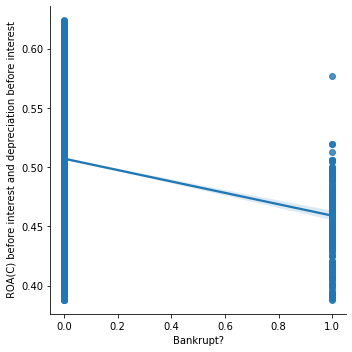

<Figure size 648x432 with 0 Axes>

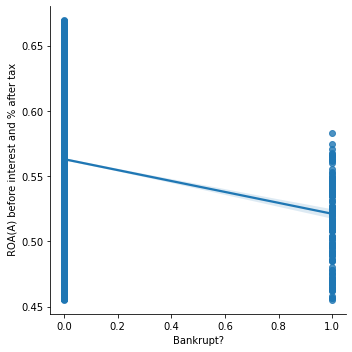

<Figure size 648x432 with 0 Axes>

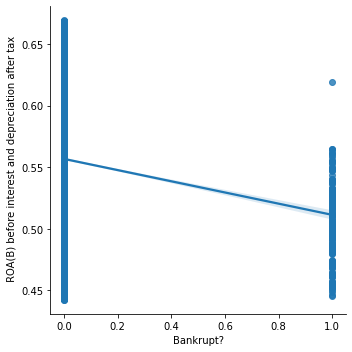

<Figure size 648x432 with 0 Axes>

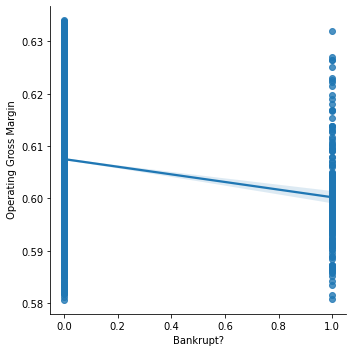

<Figure size 648x432 with 0 Axes>

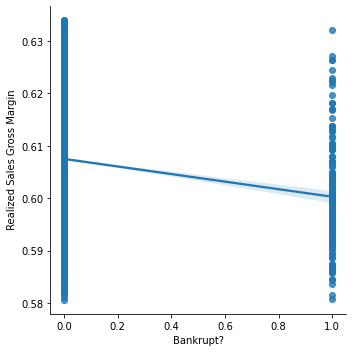

<Figure size 648x432 with 0 Axes>

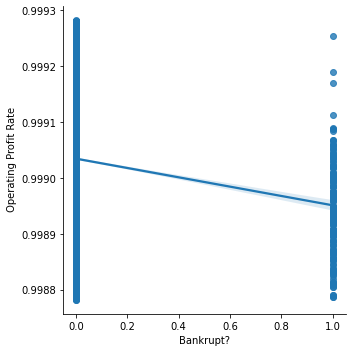

<Figure size 648x432 with 0 Axes>

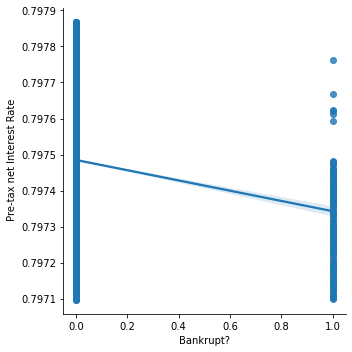

<Figure size 648x432 with 0 Axes>

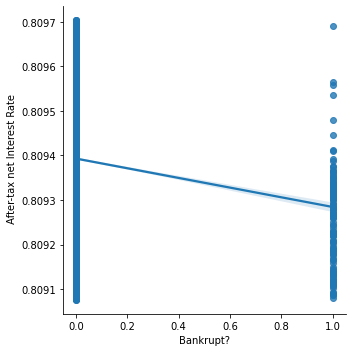

<Figure size 648x432 with 0 Axes>

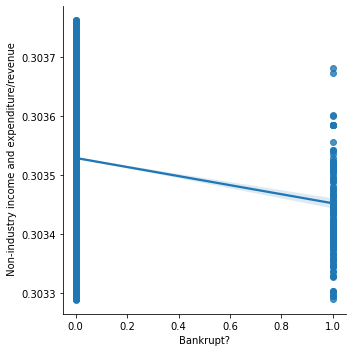

<Figure size 648x432 with 0 Axes>

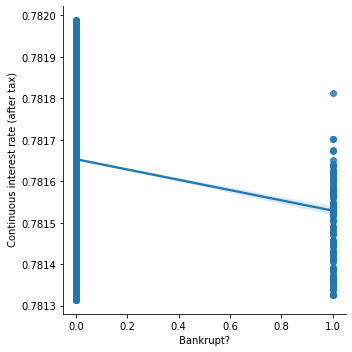

<Figure size 648x432 with 0 Axes>

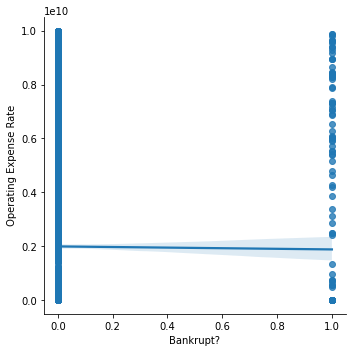

<Figure size 648x432 with 0 Axes>

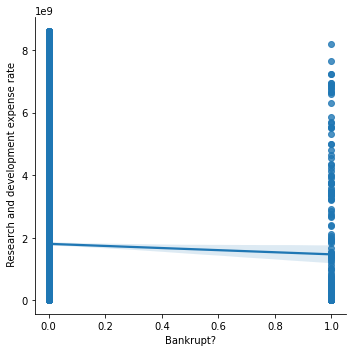

<Figure size 648x432 with 0 Axes>

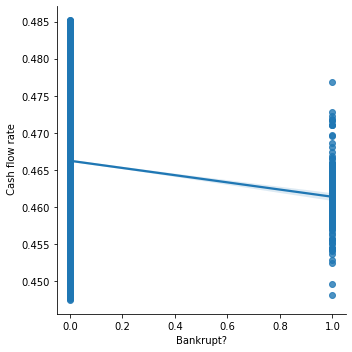

<Figure size 648x432 with 0 Axes>

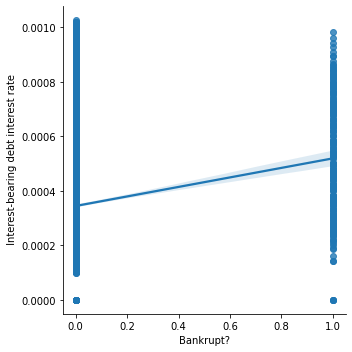

<Figure size 648x432 with 0 Axes>

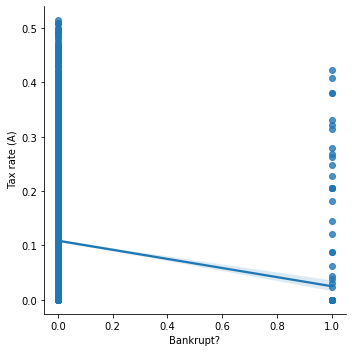

<Figure size 648x432 with 0 Axes>

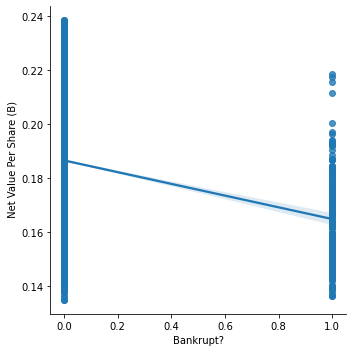

<Figure size 648x432 with 0 Axes>

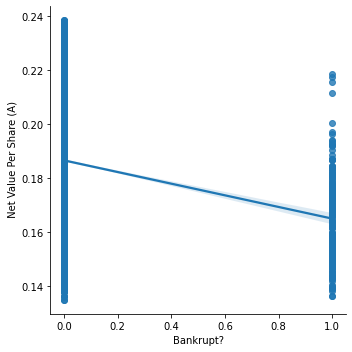

<Figure size 648x432 with 0 Axes>

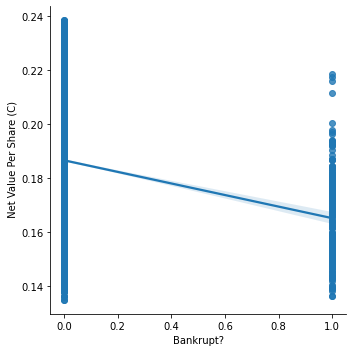

<Figure size 648x432 with 0 Axes>

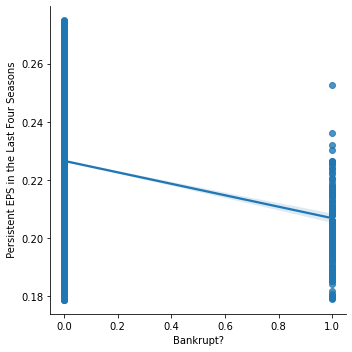

<Figure size 648x432 with 0 Axes>

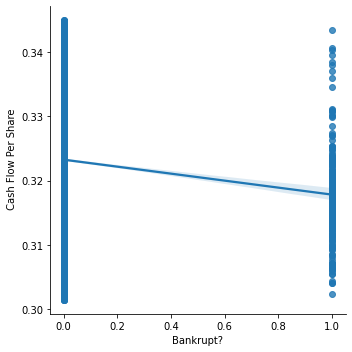

<Figure size 648x432 with 0 Axes>

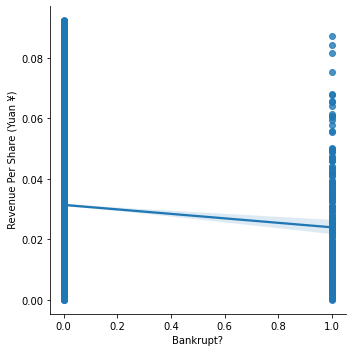

<Figure size 648x432 with 0 Axes>

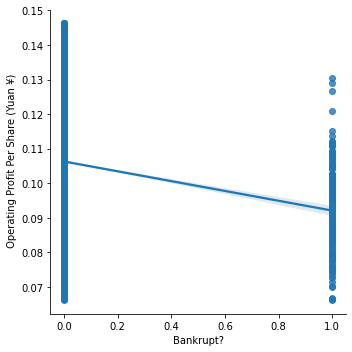

<Figure size 648x432 with 0 Axes>

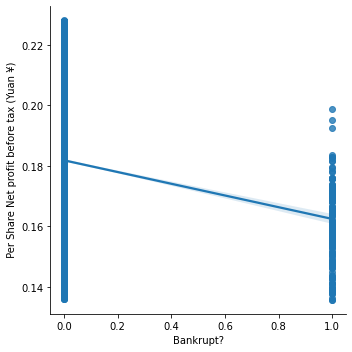

<Figure size 648x432 with 0 Axes>

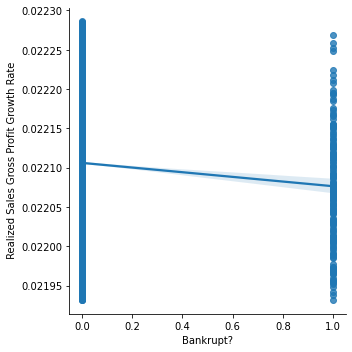

<Figure size 648x432 with 0 Axes>

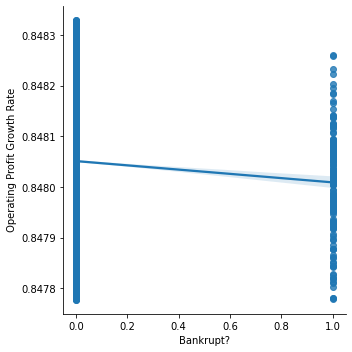

<Figure size 648x432 with 0 Axes>

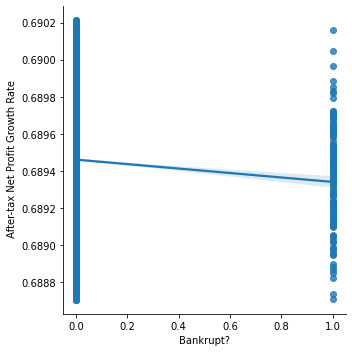

<Figure size 648x432 with 0 Axes>

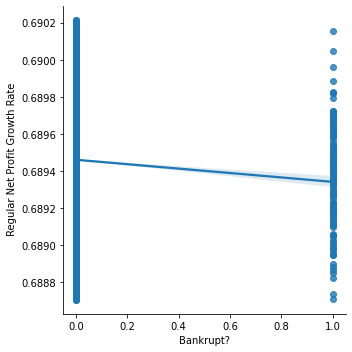

<Figure size 648x432 with 0 Axes>

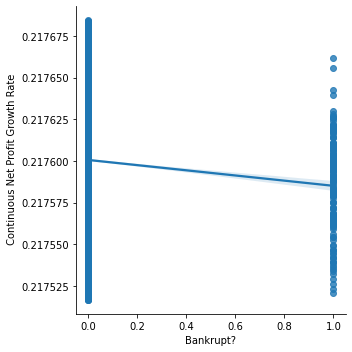

<Figure size 648x432 with 0 Axes>

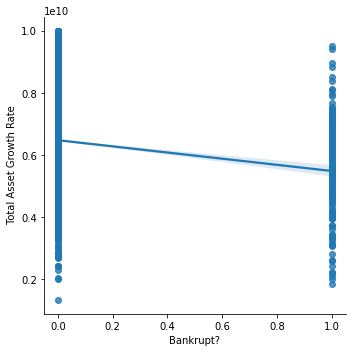

<Figure size 648x432 with 0 Axes>

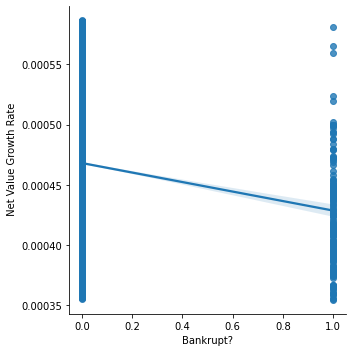

<Figure size 648x432 with 0 Axes>

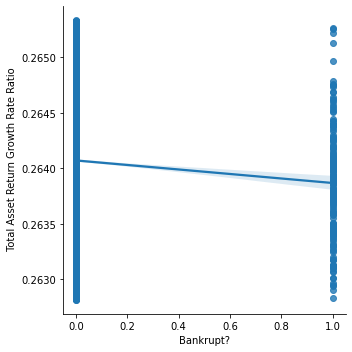

<Figure size 648x432 with 0 Axes>

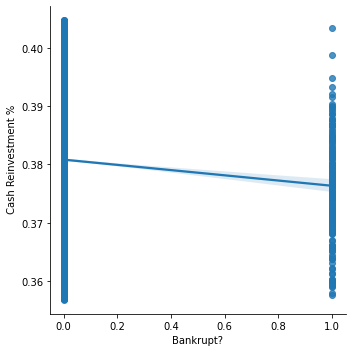

<Figure size 648x432 with 0 Axes>

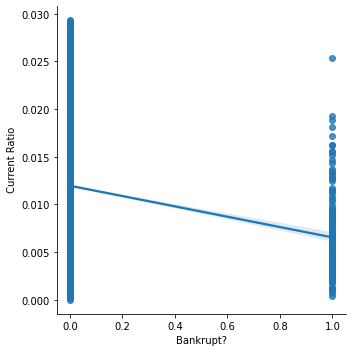

<Figure size 648x432 with 0 Axes>

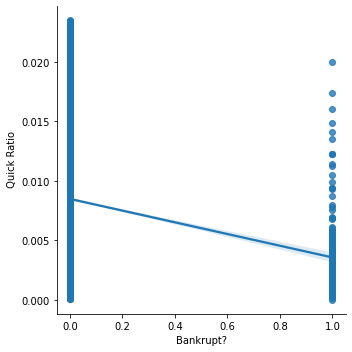

<Figure size 648x432 with 0 Axes>

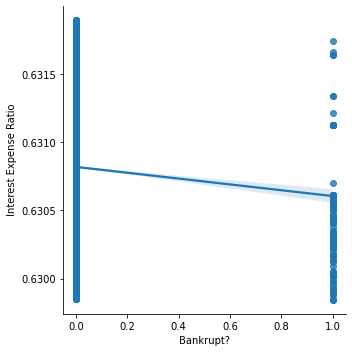

<Figure size 648x432 with 0 Axes>

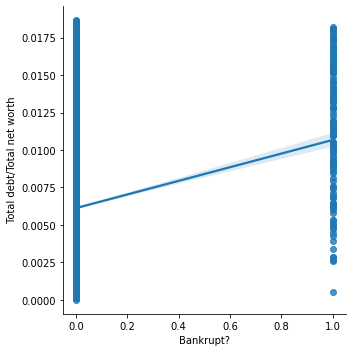

<Figure size 648x432 with 0 Axes>

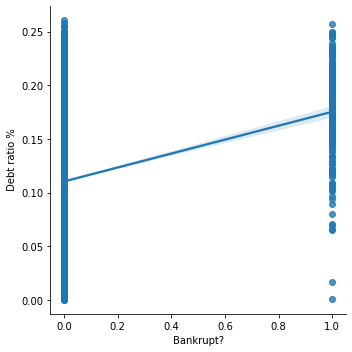

<Figure size 648x432 with 0 Axes>

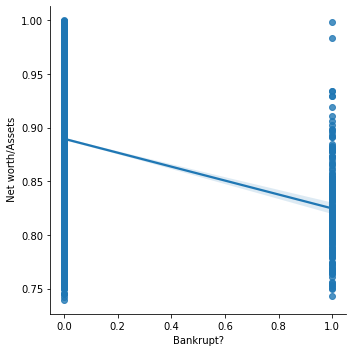

<Figure size 648x432 with 0 Axes>

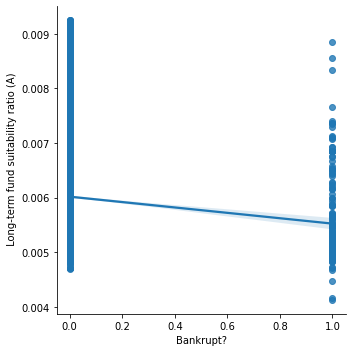

<Figure size 648x432 with 0 Axes>

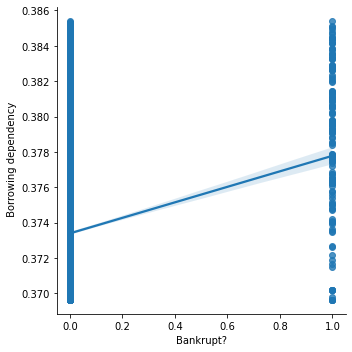

<Figure size 648x432 with 0 Axes>

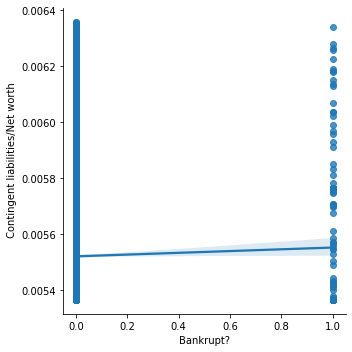

<Figure size 648x432 with 0 Axes>

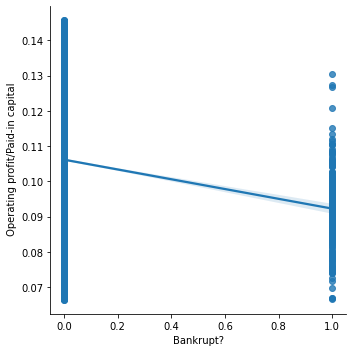

<Figure size 648x432 with 0 Axes>

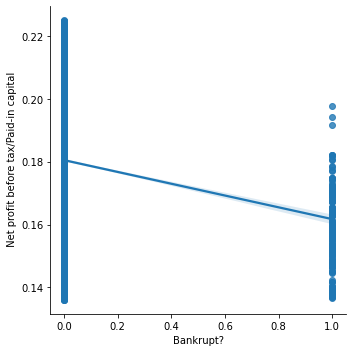

<Figure size 648x432 with 0 Axes>

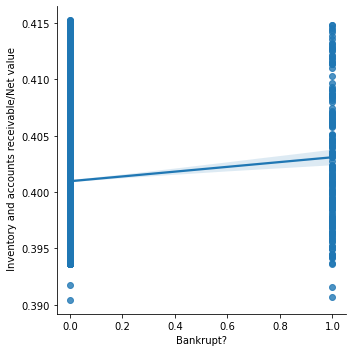

<Figure size 648x432 with 0 Axes>

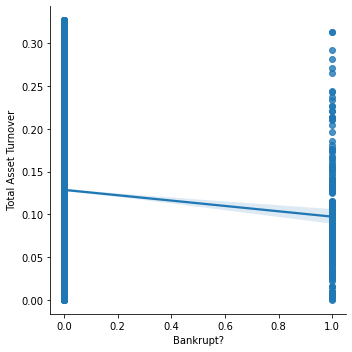

<Figure size 648x432 with 0 Axes>

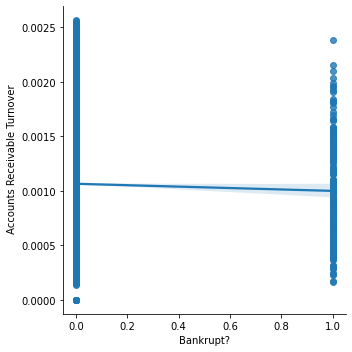

<Figure size 648x432 with 0 Axes>

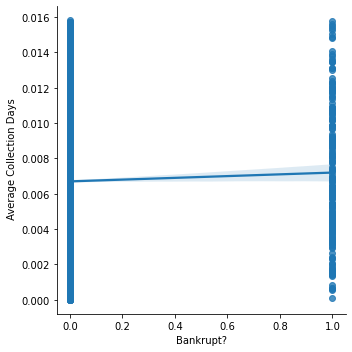

<Figure size 648x432 with 0 Axes>

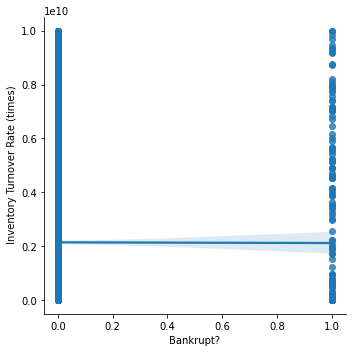

<Figure size 648x432 with 0 Axes>

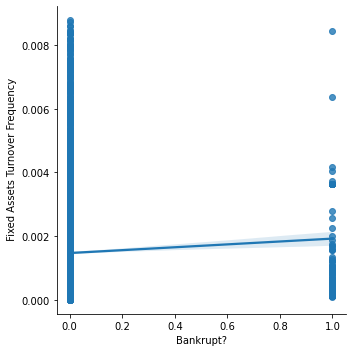

<Figure size 648x432 with 0 Axes>

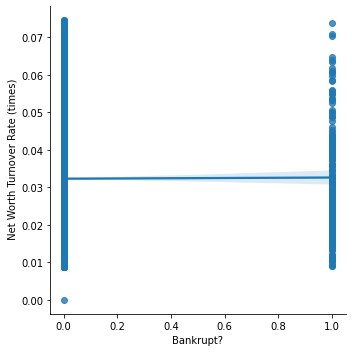

<Figure size 648x432 with 0 Axes>

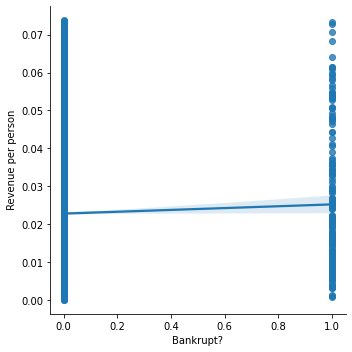

<Figure size 648x432 with 0 Axes>

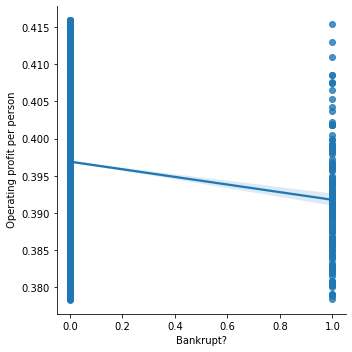

<Figure size 648x432 with 0 Axes>

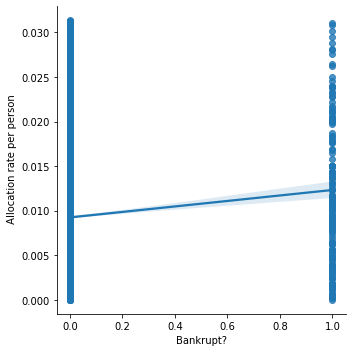

<Figure size 648x432 with 0 Axes>

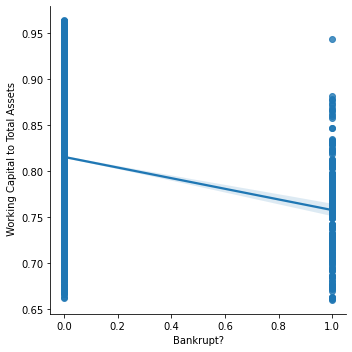

<Figure size 648x432 with 0 Axes>

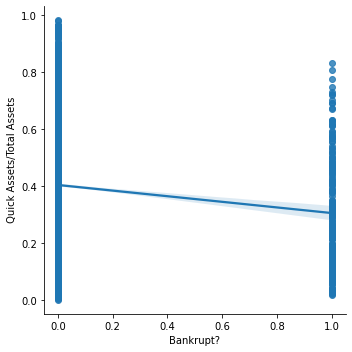

<Figure size 648x432 with 0 Axes>

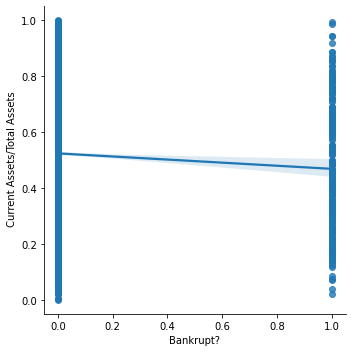

<Figure size 648x432 with 0 Axes>

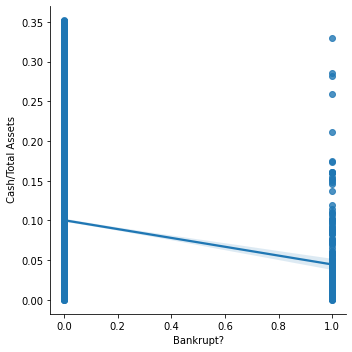

<Figure size 648x432 with 0 Axes>

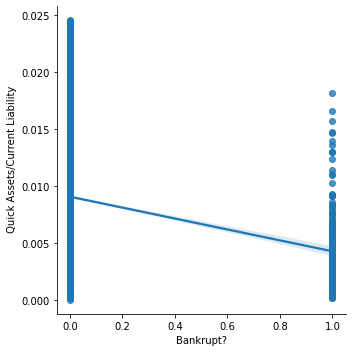

<Figure size 648x432 with 0 Axes>

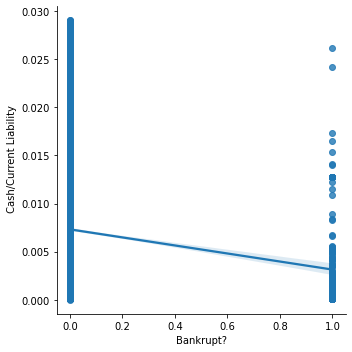

<Figure size 648x432 with 0 Axes>

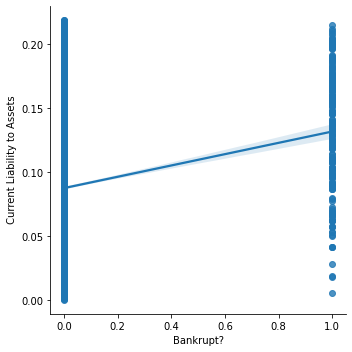

<Figure size 648x432 with 0 Axes>

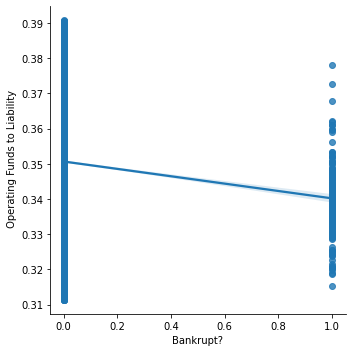

<Figure size 648x432 with 0 Axes>

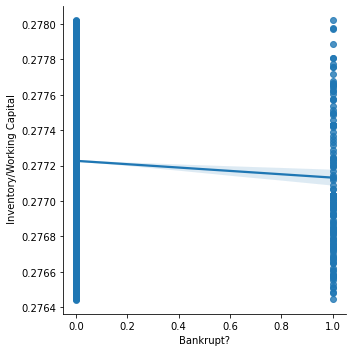

<Figure size 648x432 with 0 Axes>

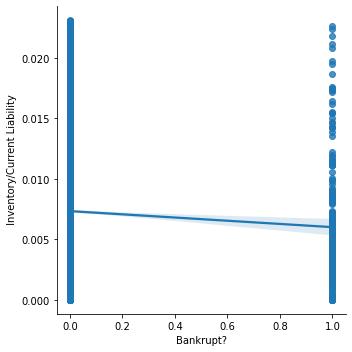

<Figure size 648x432 with 0 Axes>

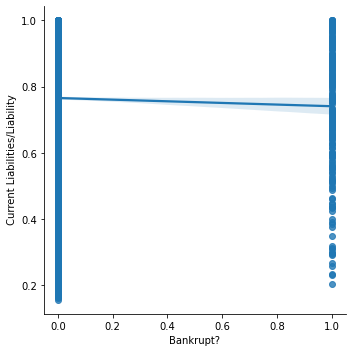

<Figure size 648x432 with 0 Axes>

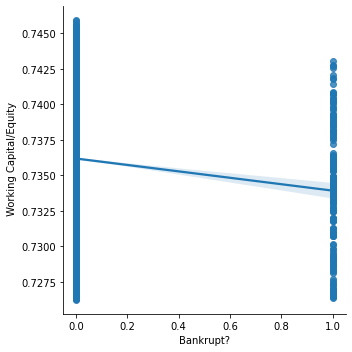

<Figure size 648x432 with 0 Axes>

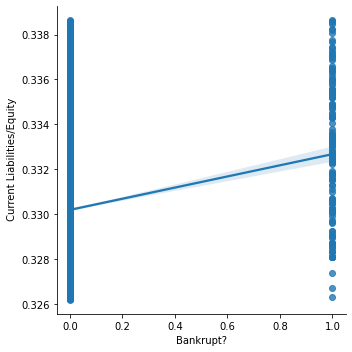

<Figure size 648x432 with 0 Axes>

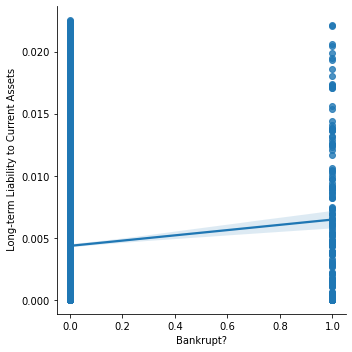

<Figure size 648x432 with 0 Axes>

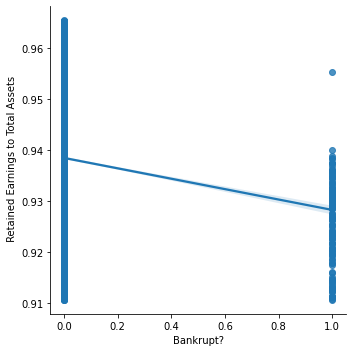

<Figure size 648x432 with 0 Axes>

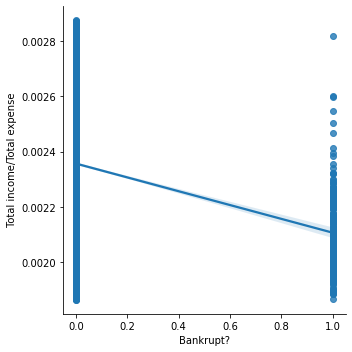

<Figure size 648x432 with 0 Axes>

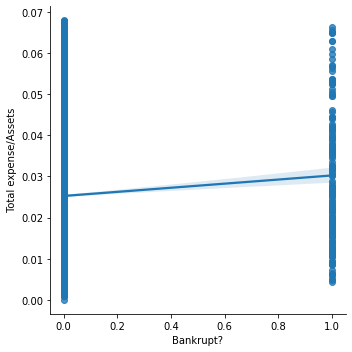

<Figure size 648x432 with 0 Axes>

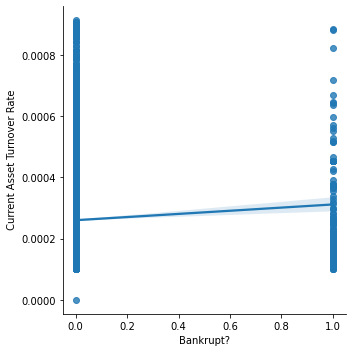

<Figure size 648x432 with 0 Axes>

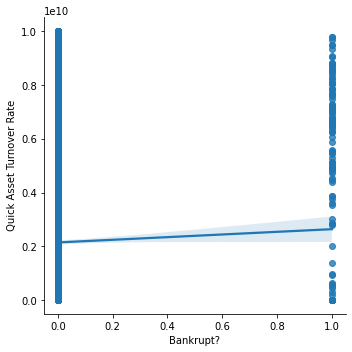

<Figure size 648x432 with 0 Axes>

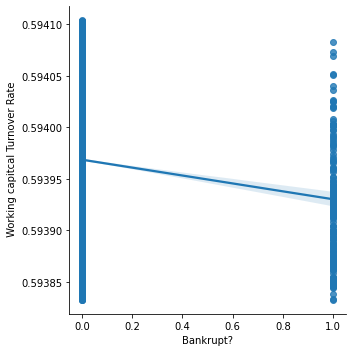

<Figure size 648x432 with 0 Axes>

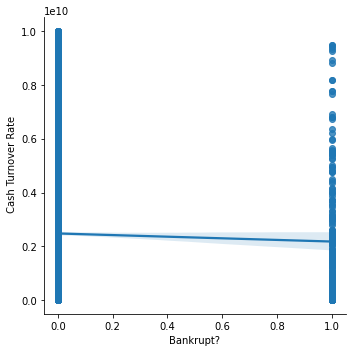

<Figure size 648x432 with 0 Axes>

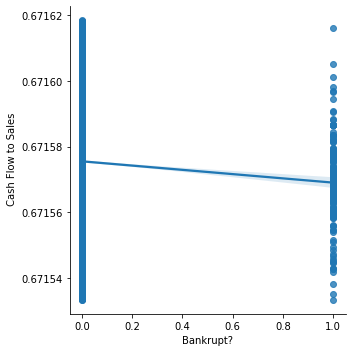

<Figure size 648x432 with 0 Axes>

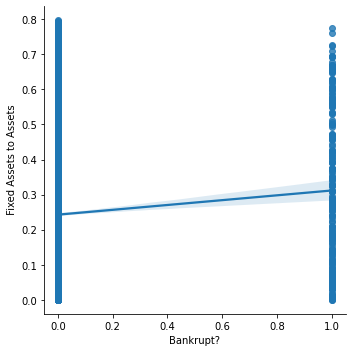

<Figure size 648x432 with 0 Axes>

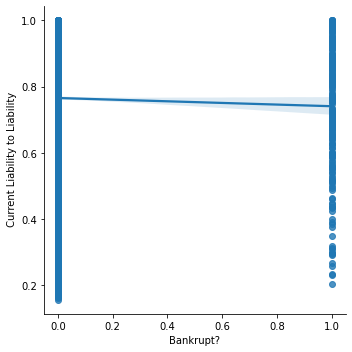

<Figure size 648x432 with 0 Axes>

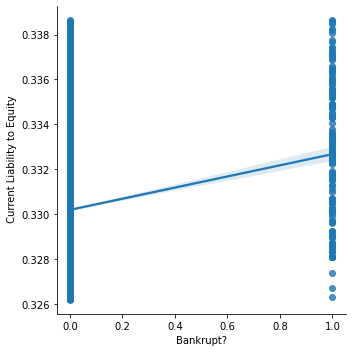

<Figure size 648x432 with 0 Axes>

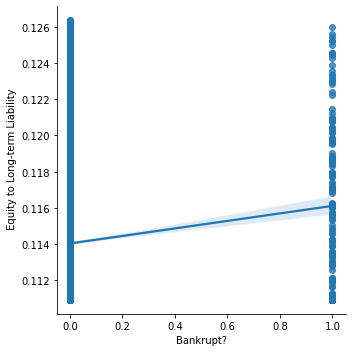

<Figure size 648x432 with 0 Axes>

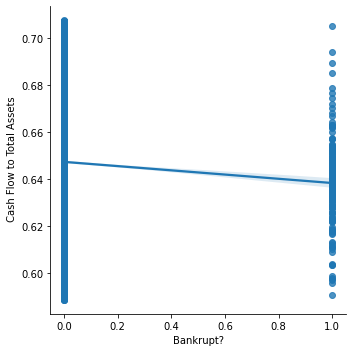

<Figure size 648x432 with 0 Axes>

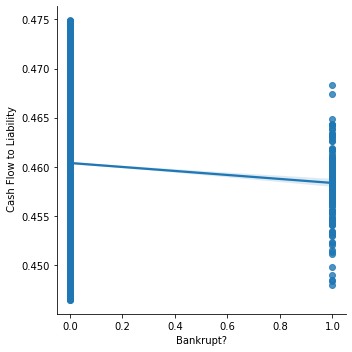

<Figure size 648x432 with 0 Axes>

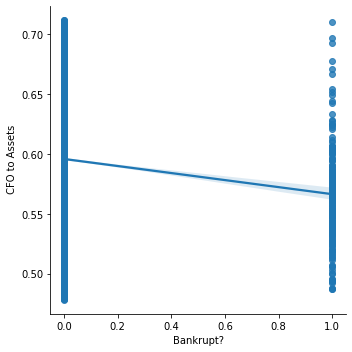

<Figure size 648x432 with 0 Axes>

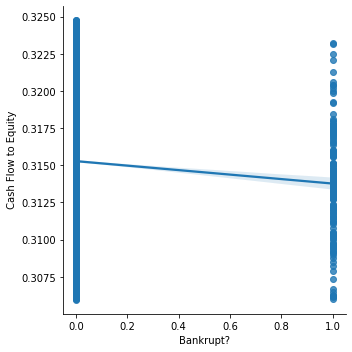

<Figure size 648x432 with 0 Axes>

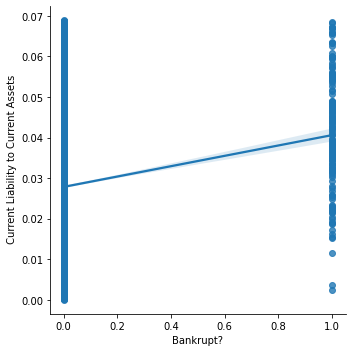

<Figure size 648x432 with 0 Axes>

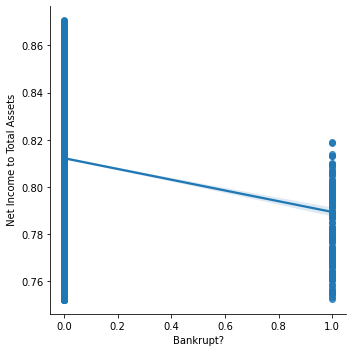

<Figure size 648x432 with 0 Axes>

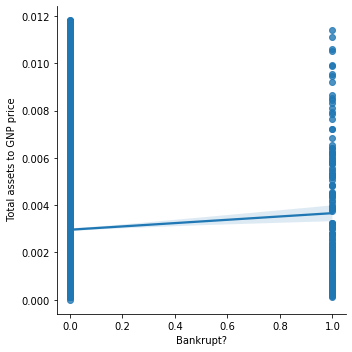

<Figure size 648x432 with 0 Axes>

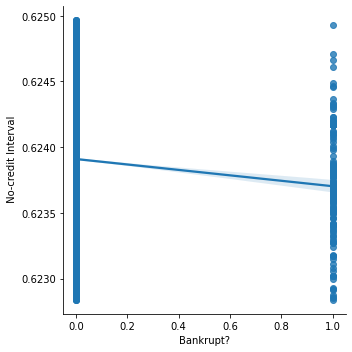

<Figure size 648x432 with 0 Axes>

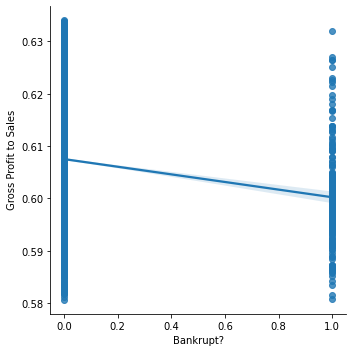

<Figure size 648x432 with 0 Axes>

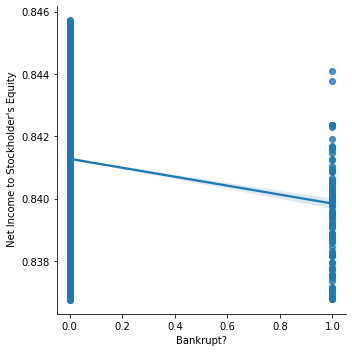

<Figure size 648x432 with 0 Axes>

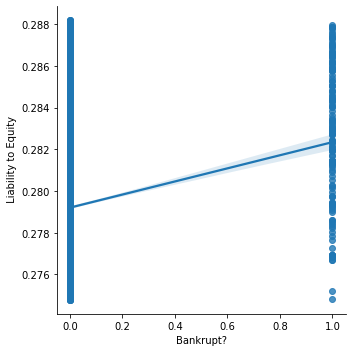

<Figure size 648x432 with 0 Axes>

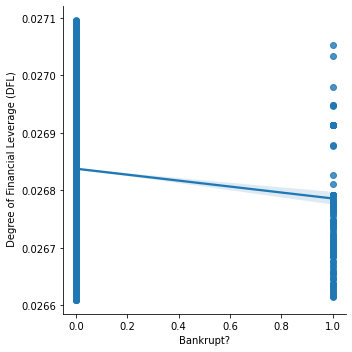

<Figure size 648x432 with 0 Axes>

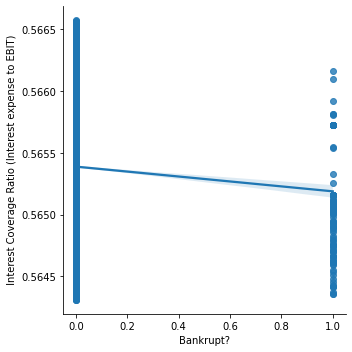

<Figure size 648x432 with 0 Axes>

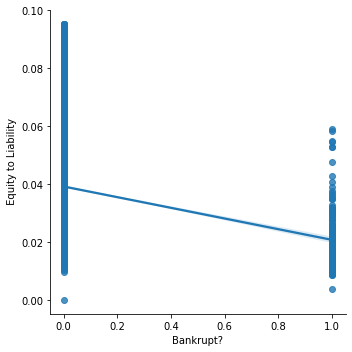

In [126]:
# LM plot showing relation between Dependent and Independent Variables. 

for i in columns:
  fig = plt.figure(figsize=(9, 6))
  # ax = fig.gca()
  # df.boxplot(column = i, by = 'Bankrupt?', ax = ax)
  # ax.set_ylabel(i)
  sns.lmplot(x='Bankrupt?', y=i, data=df)
  plt.show()

**CONCLUSION--**
1. Bankruptcy is more likely, if the value of features such as ROA(A) value is low.
2. Value of features such as Current Liability to current Assets is more likely to cause bankruptcy.
3. For higher values of features like Retained Earnings to Total Assets, a company is likely to stay aﬂoat.


##<h1> Feature Selection

<h3>1. Using Random Forest

In [127]:
# creating the copy of original dataframe.

df1 = df.iloc[:,1:].copy()
X = df1
Y = df['Bankrupt?']

In [128]:
# using Gini entropy as the parameter.

rf = RandomForestClassifier(n_estimators=100,criterion='gini',class_weight='balanced',random_state= 21,n_jobs=-1)

In [129]:
#fitting the model
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [130]:
feature_importance_df = pd.DataFrame(rf.feature_importances_)
feature_importance_df.shape

(93, 1)

In [131]:
concatenated_imp_df = pd.concat([pd.DataFrame(X.columns),feature_importance_df],axis=1)
concatenated_imp_df.columns=['features','imp']
concatenated_imp_df = concatenated_imp_df.sort_values(by='imp',ascending=False)
#Chosing out top 25 columns
#final_df = concatenated_imp_df.head(25)
concatenated_imp_df.head(5)

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351


In [132]:
concatenated_imp_df.tail(5)

,features,imp
47,Inventory Turnover Rate (times),0.003185
76,Current Liability to Liability,0.003177
86,No-credit Interval,0.003161
43,Inventory and accounts receivable/Net value,0.002677
40,Contingent liabilities/Net worth,0.001599


**These are top 5 and bottom 5 features.**

In [133]:
concatenated_imp_df.iloc[:26]

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


In [134]:
# Chosing out top 25 columns
final_df = concatenated_imp_df.head(25)
final_df

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


<h3> 2. Using Information Gain.

In [135]:
# create a dataframe which consist of Features along with their Importances.
from sklearn.feature_selection import mutual_info_classif
feature_importance = mutual_info_classif(X,Y)
feature_df = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(feature_importance)],axis=1)
feature_df.columns = ['Features','Importances']
feature_df = feature_df.sort_values(by='Importances',ascending=False)


In [136]:
feature_df.tail(5)

,Features,Importances
49,Net Worth Turnover Rate (times),0.000000
47,Inventory Turnover Rate (times),0.000000
40,Contingent liabilities/Net worth,0.000000
11,Research and development expense rate,0.000000
70,Current Asset Turnover Rate,0.000000


In [137]:
feature_df.head(5)

,Features,Importances
18,Persistent EPS in the Last Four Seasons,0.042079
88,Net Income to Stockholder's Equity,0.039698
42,Net profit before tax/Paid-in capital,0.039111
22,Per Share Net profit before tax (Yuan ¥),0.036674
9,Continuous interest rate (after tax),0.036058


In [138]:
feature_df.iloc[40:50]

,Features,Importances
64,Working Capital/Equity,0.019054
59,Current Liability to Assets,0.017858
5,Operating Profit Rate,0.017302
58,Cash/Current Liability,0.016816
60,Operating Funds to Liability,0.015584
56,Cash/Total Assets,0.015094
3,Operating Gross Margin,0.014794
25,After-tax Net Profit Growth Rate,0.014652
12,Cash flow rate,0.014012
4,Realized Sales Gross Margin,0.012487


In [139]:
#Top 50 important features
final_features_df = feature_df.head(50)

**Taking out top 50 features from Information Gain Algorithm**

In [140]:
list_rf = final_df['features'].values.tolist()
list_ig = final_features_df['Features'].values.tolist()

In [141]:
final_list = list((set(list_rf)).intersection(set(list_ig)))
temp_list = final_list.copy()
len(temp_list)

23

In [142]:
# list consisting intersection of Random Forest and Information Gain Algorithm.
temp_list

[' Debt ratio %',
 ' Borrowing dependency',
 ' Total debt/Total net worth',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Net Income to Total Assets',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (C)',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(B) before interest and depreciation after tax',
 " Net Income to Stockholder's Equity",
 ' Net worth/Assets',
 ' Retained Earnings to Total Assets',
 ' Equity to Liability',
 ' Liability to Equity',
 ' Non-industry income and expenditure/revenue',
 ' Current Ratio',
 ' Total income/Total expense',
 ' Net profit before tax/Paid-in capital',
 ' Quick Ratio',
 ' ROA(A) before interest and % after tax',
 ' After-tax net Interest Rate',
 ' Persistent EPS in the Last Four Seasons',
 ' Continuous interest rate (after tax)']

**We have taken the Intersection from the features of both Algo. We've reduced to 23 features**

In [143]:
final_features_df = df[final_list]
final_features_df.head()

,Debt ratio %,Borrowing dependency,Total debt/Total net worth,Per Share Net profit before tax (Yuan ¥),Net Income to Total Assets,Net Value Per Share (B),Net Value Per Share (C),ROA(C) before interest and depreciation before interest,ROA(B) before interest and depreciation after tax,Net Income to Stockholder's Equity,Net worth/Assets,Retained Earnings to Total Assets,Equity to Liability,Liability to Equity,Non-industry income and expenditure/revenue,Current Ratio,Total income/Total expense,Net profit before tax/Paid-in capital,Quick Ratio,ROA(A) before interest and % after tax,After-tax net Interest Rate,Persistent EPS in the Last Four Seasons,Continuous interest rate (after tax)
0,0.207576,0.376271,0.009273,0.138736,0.796750,0.147950,0.147950,0.476527,0.527277,0.840115,0.792424,0.931097,0.016469,0.281449,0.303466,0.002259,0.002022,0.137757,0.001208,0.535543,0.809312,0.214711,0.781567
1,0.171176,0.376760,0.012502,0.169918,0.795297,0.182251,0.182251,0.464291,0.516730,0.839969,0.828824,0.931065,0.020794,0.283846,0.303556,0.006016,0.002226,0.168962,0.004039,0.538214,0.809301,0.208944,0.781506
2,0.207516,0.379093,0.009273,0.142803,0.774670,0.177911,0.193713,0.426071,0.472295,0.836774,0.792484,0.931097,0.016474,0.281449,0.303466,0.011543,0.002060,0.148036,0.005348,0.499019,0.809312,0.180581,0.781567
3,0.151465,0.379743,0.009572,0.148603,0.796750,0.154187,0.154187,0.399844,0.457733,0.840115,0.848535,0.931097,0.023982,0.281721,0.303350,0.004194,0.002236,0.147561,0.002896,0.535543,0.809312,0.193722,0.781567
4,0.106509,0.375025,0.005150,0.168412,0.795016,0.167502,0.167502,0.465022,0.522298,0.839973,0.893491,0.913850,0.035490,0.278514,0.303475,0.006022,0.002224,0.167461,0.003727,0.538432,0.809304,0.212537,0.781550


In [144]:
final_list.append('Bankrupt?')
final_list

[' Debt ratio %',
 ' Borrowing dependency',
 ' Total debt/Total net worth',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Net Income to Total Assets',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (C)',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(B) before interest and depreciation after tax',
 " Net Income to Stockholder's Equity",
 ' Net worth/Assets',
 ' Retained Earnings to Total Assets',
 ' Equity to Liability',
 ' Liability to Equity',
 ' Non-industry income and expenditure/revenue',
 ' Current Ratio',
 ' Total income/Total expense',
 ' Net profit before tax/Paid-in capital',
 ' Quick Ratio',
 ' ROA(A) before interest and % after tax',
 ' After-tax net Interest Rate',
 ' Persistent EPS in the Last Four Seasons',
 ' Continuous interest rate (after tax)',
 'Bankrupt?']

In [145]:
final_company_df = df[final_list]
final_company_df

,Debt ratio %,Borrowing dependency,Total debt/Total net worth,Per Share Net profit before tax (Yuan ¥),Net Income to Total Assets,Net Value Per Share (B),Net Value Per Share (C),ROA(C) before interest and depreciation before interest,ROA(B) before interest and depreciation after tax,Net Income to Stockholder's Equity,Net worth/Assets,Retained Earnings to Total Assets,Equity to Liability,Liability to Equity,Non-industry income and expenditure/revenue,Current Ratio,Total income/Total expense,Net profit before tax/Paid-in capital,Quick Ratio,ROA(A) before interest and % after tax,After-tax net Interest Rate,Persistent EPS in the Last Four Seasons,Continuous interest rate (after tax),Bankrupt?
0,0.207576,0.376271,0.009273,0.138736,0.796750,0.147950,0.147950,0.476527,0.527277,0.840115,0.792424,0.931097,0.016469,0.281449,0.303466,0.002259,0.002022,0.137757,0.001208,0.535543,0.809312,0.214711,0.781567,1
1,0.171176,0.376760,0.012502,0.169918,0.795297,0.182251,0.182251,0.464291,0.516730,0.839969,0.828824,0.931065,0.020794,0.283846,0.303556,0.006016,0.002226,0.168962,0.004039,0.538214,0.809301,0.208944,0.781506,1
2,0.207516,0.379093,0.009273,0.142803,0.774670,0.177911,0.193713,0.426071,0.472295,0.836774,0.792484,0.931097,0.016474,0.281449,0.303466,0.011543,0.002060,0.148036,0.005348,0.499019,0.809312,0.180581,0.781567,1
3,0.151465,0.379743,0.009572,0.148603,0.796750,0.154187,0.154187,0.399844,0.457733,0.840115,0.848535,0.931097,0.023982,0.281721,0.303350,0.004194,0.002236,0.147561,0.002896,0.535543,0.809312,0.193722,0.781567,1
4,0.106509,0.375025,0.005150,0.168412,0.795016,0.167502,0.167502,0.465022,0.522298,0.839973,0.893491,0.913850,0.035490,0.278514,0.303475,0.006022,0.002224,0.167461,0.003727,0.538432,0.809304,0.212537,0.781550,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.124618,0.373823,0.006655,0.172102,0.799927,0.175045,0.175045,0.493687,0.543230,0.840359,0.875382,0.925611,0.029890,0.279606,0.303510,0.010451,0.002266,0.171111,0.005457,0.539468,0.809331,0.216602,0.781588,0
6815,0.099253,0.372505,0.004623,0.172780,0.799748,0.181324,0.181324,0.475162,0.524172,0.840306,0.900747,0.932629,0.038284,0.278132,0.303520,0.009259,0.002288,0.171805,0.006741,0.538269,0.809327,0.216697,0.781586,0
6816,0.038939,0.369637,0.001392,0.173232,0.797778,0.199570,0.199612,0.472725,0.520638,0.840138,0.961061,0.932000,0.052838,0.275789,0.303512,0.016270,0.002239,0.172287,0.012249,0.533744,0.809317,0.210929,0.781546,0
6817,0.086979,0.369649,0.003816,0.185584,0.811808,0.213392,0.213392,0.506264,0.554045,0.841084,0.913021,0.939613,0.044009,0.277547,0.303498,0.012782,0.002395,0.182498,0.007256,0.559911,0.809399,0.228326,0.781663,0


In [146]:
X1 =final_company_df.drop('Bankrupt?', axis=1)
Y1 = final_company_df['Bankrupt?']

In [147]:
# function to plot distribution and box plot for selected features.

def dist_and_box(list_):
  for i in list_ :
      plt.figure(figsize=(12,6))
      plt.subplot(1, 2, 1)
      fig = sns.distplot(X1[i])
      fig.set_xlabel(i)     
      
      plt.subplot(1, 2, 2)
      fig = sns.boxplot(y=X1[i])
      fig.set_title('')
      fig.set_ylabel(i)

      plt.show()


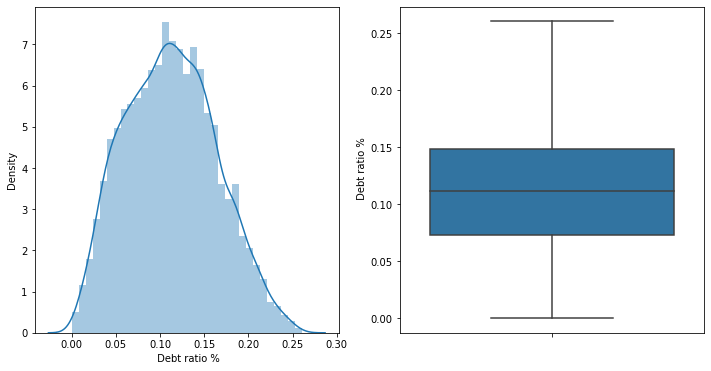

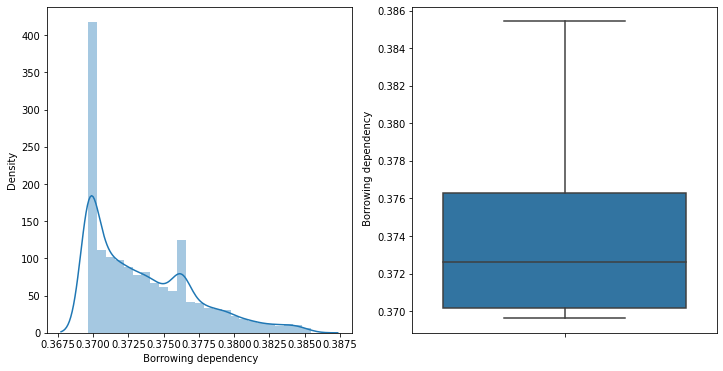

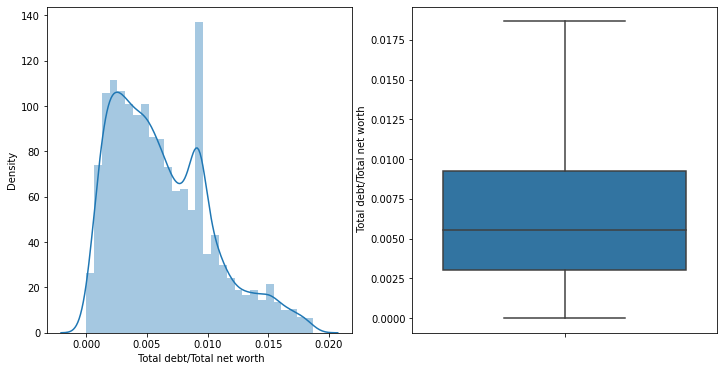

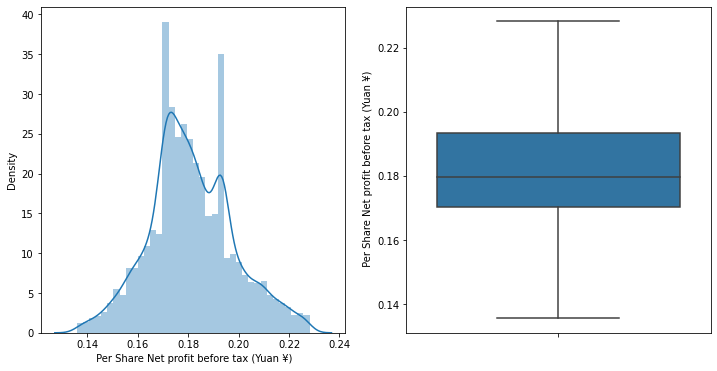

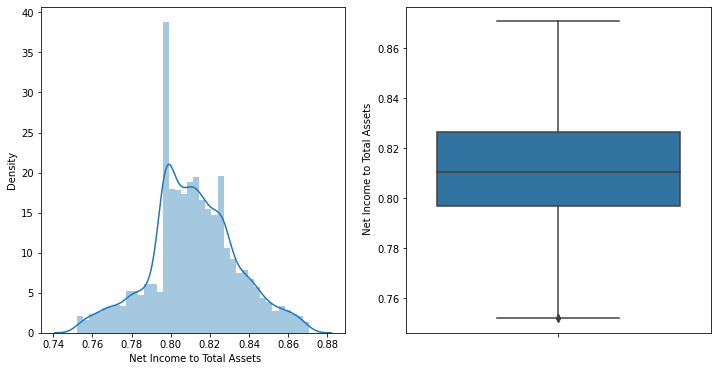

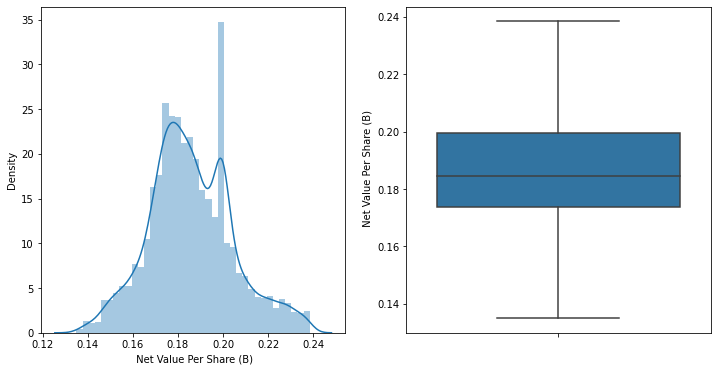

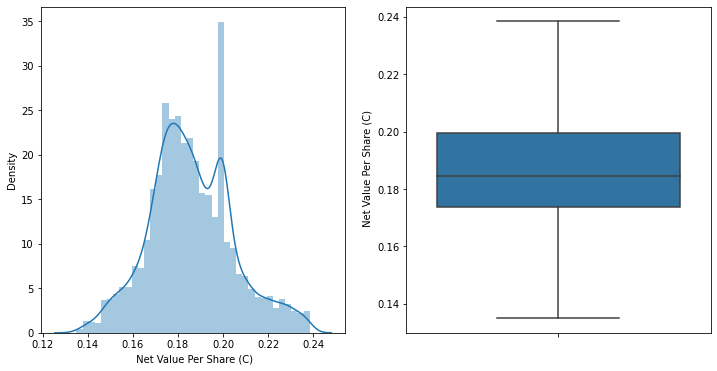

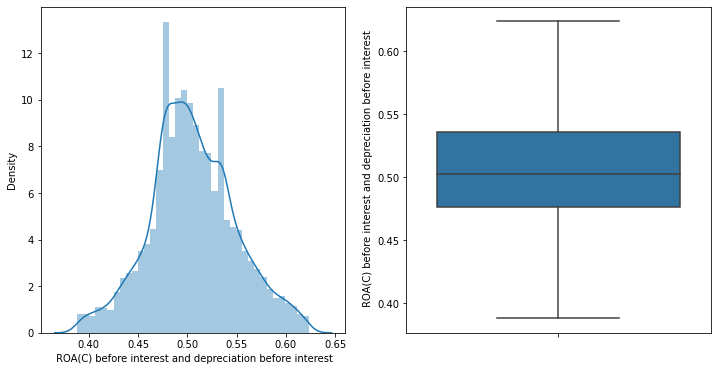

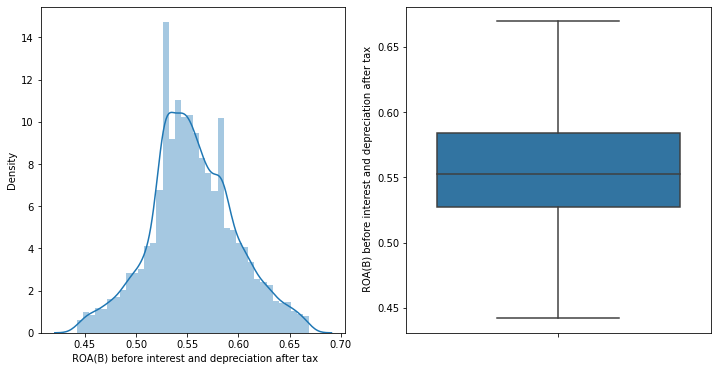

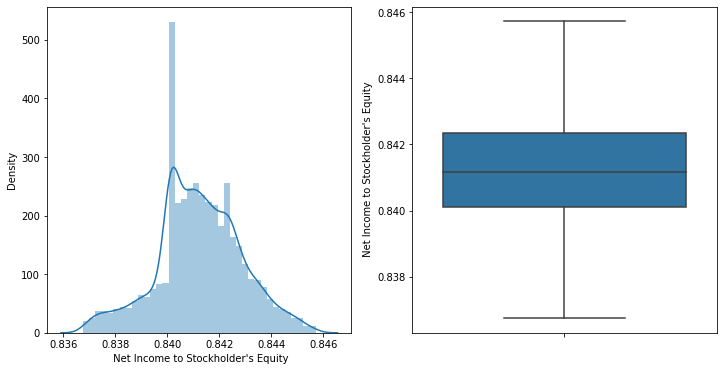

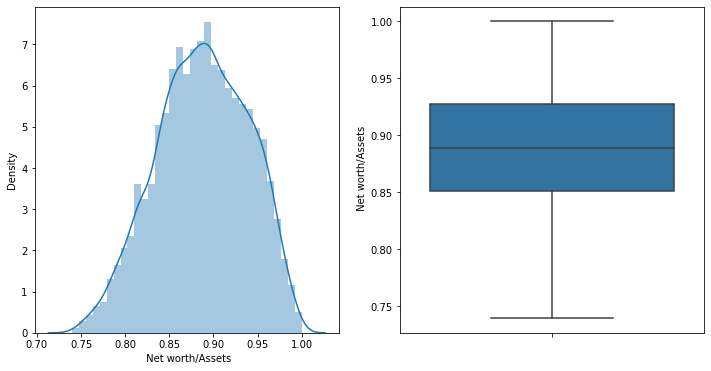

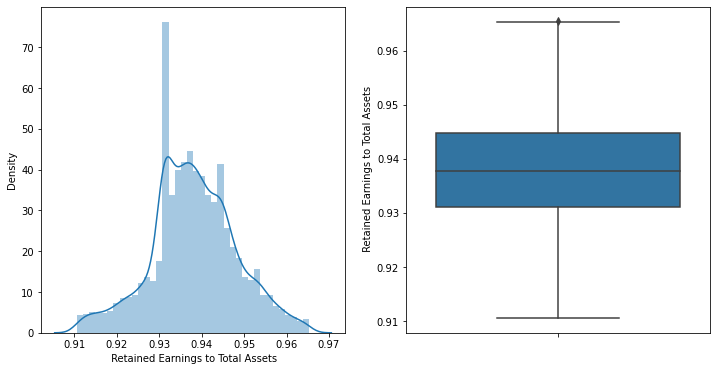

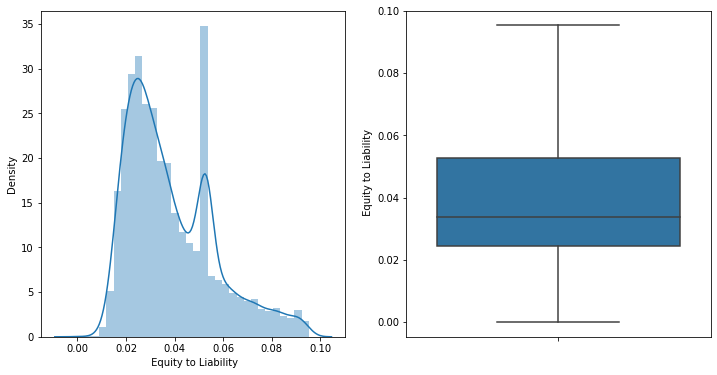

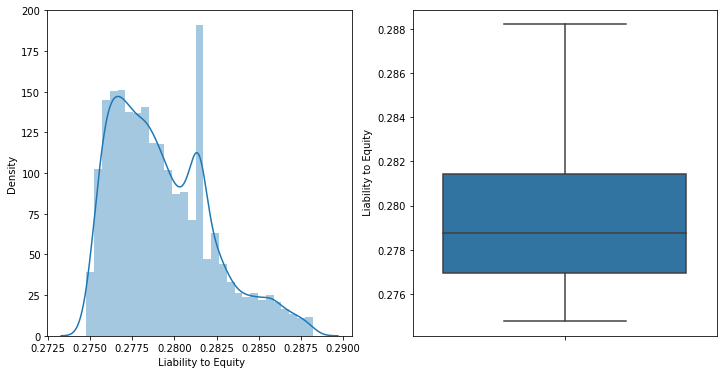

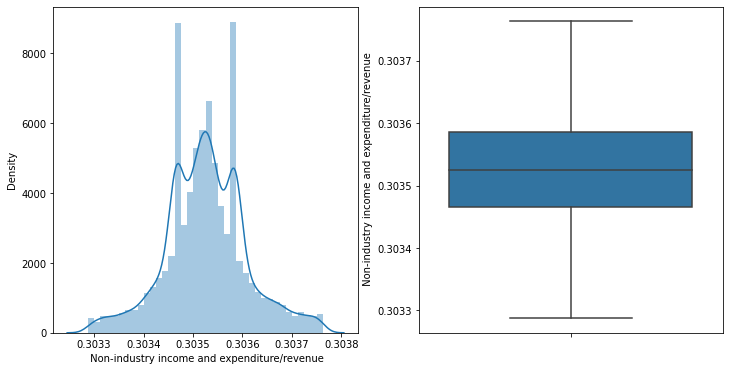

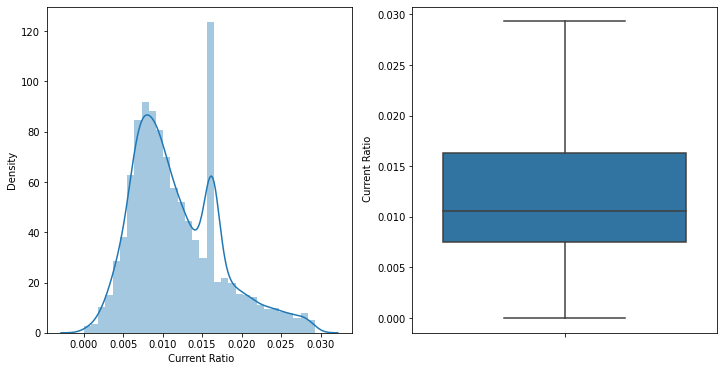

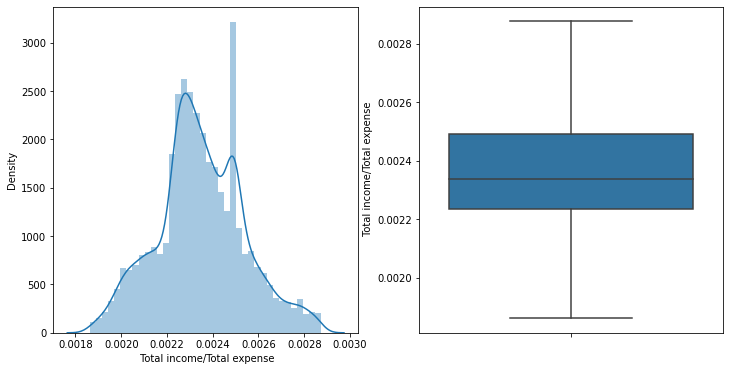

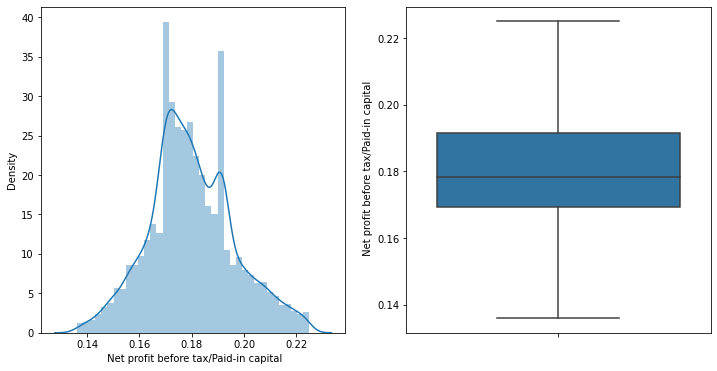

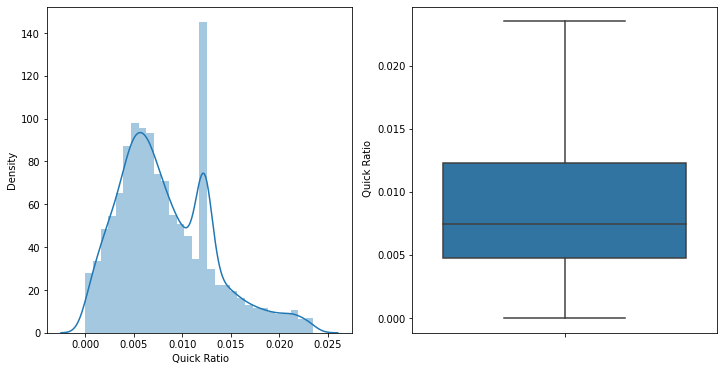

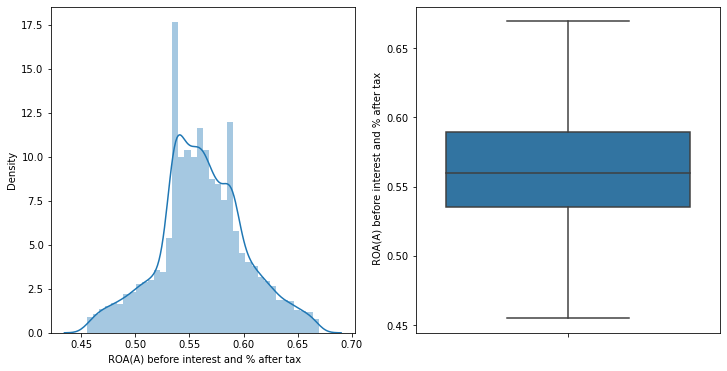

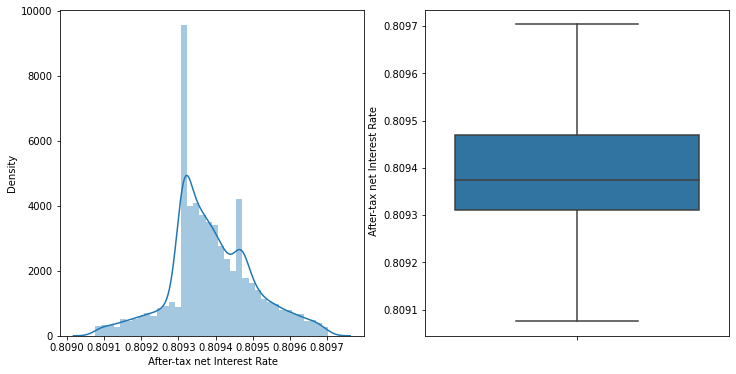

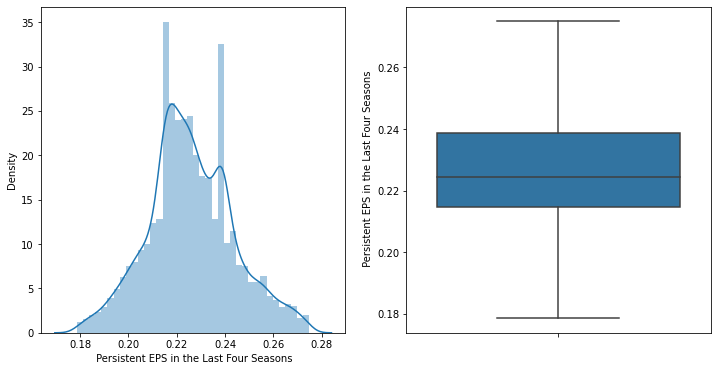

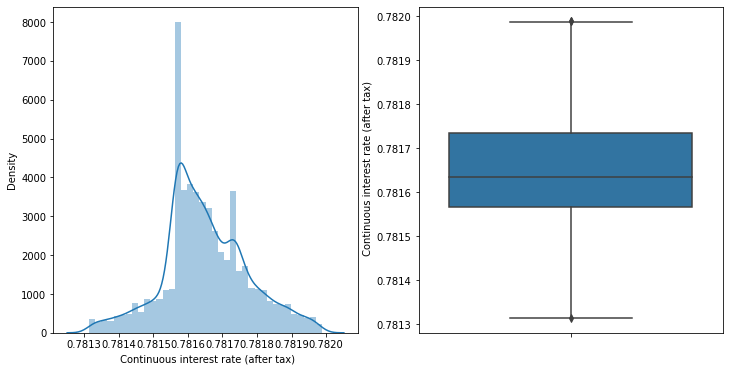

In [148]:
dist_and_box(temp_list)

**Above are the pair plot with Dependent Variable and final features after feature selection.**

<h2> Heatmap to Visualize Correlation.

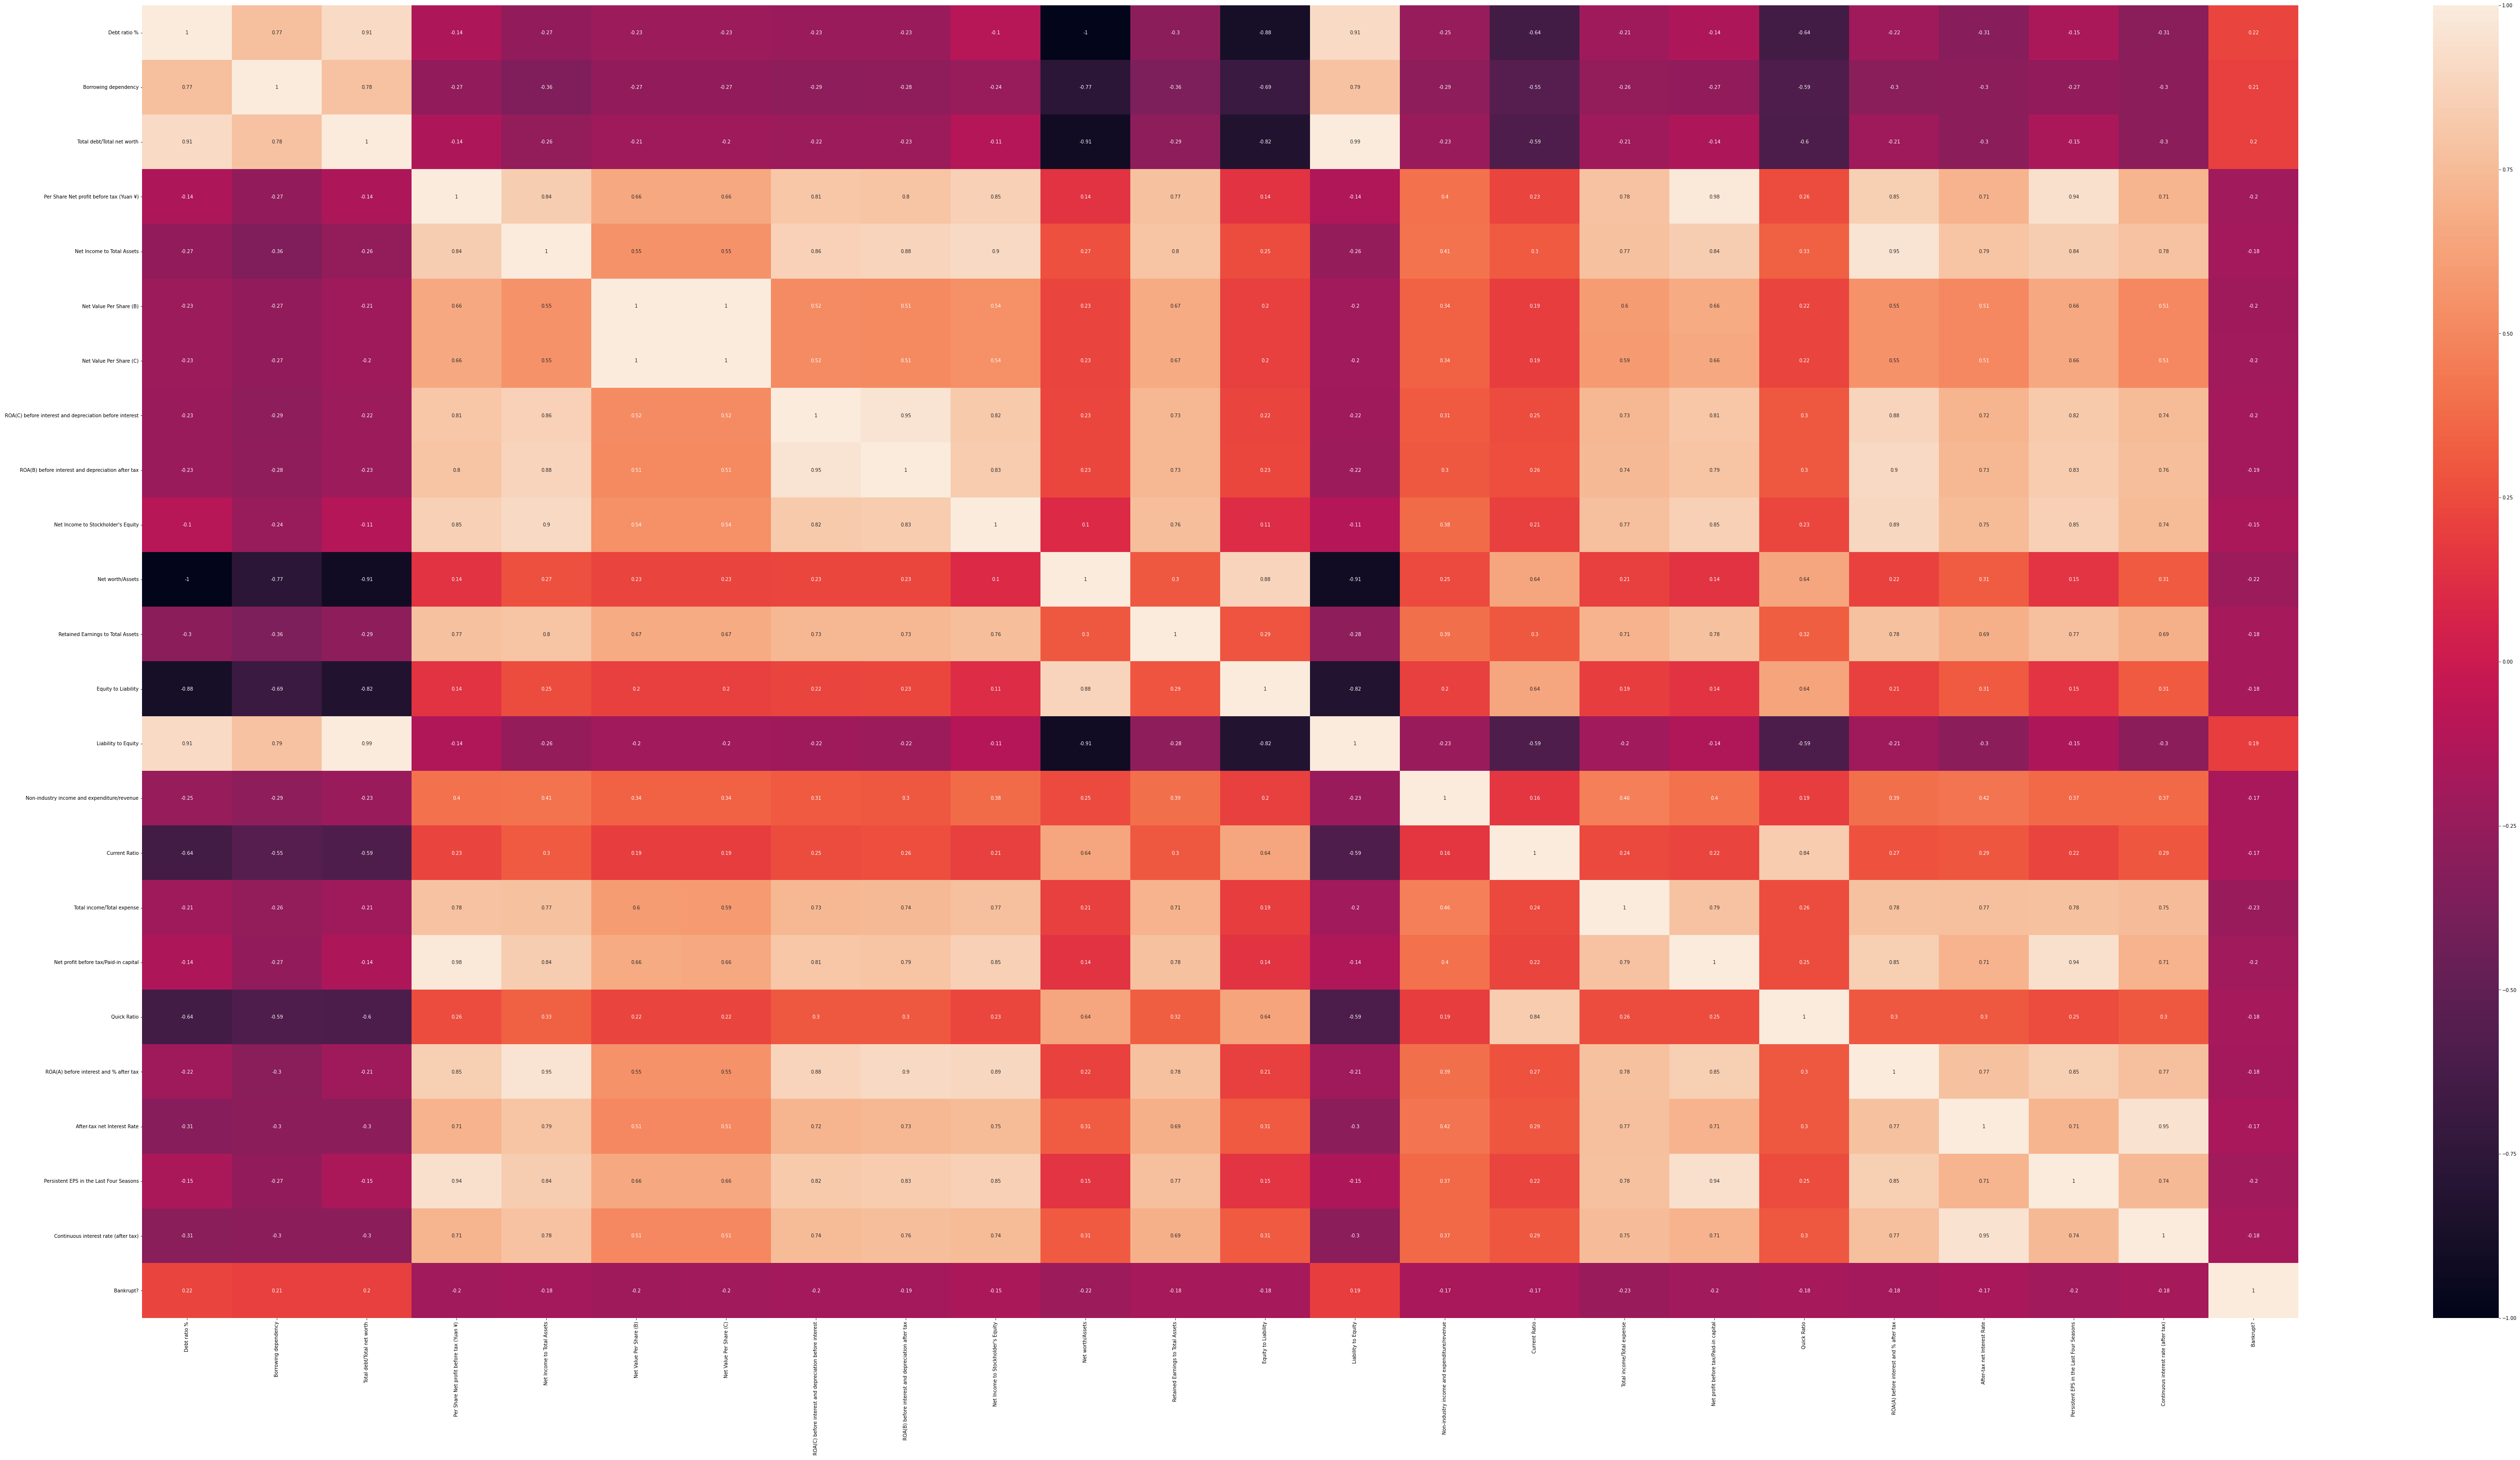

In [47]:
# heatmap to check the correlation among dependent and independent variables

fig, ax = plt.subplots(figsize=(100,50))
sns.heatmap(final_company_df.corr(), annot=True,ax = ax)

**We can see strong correlation among few features.**
1. The most negatively correlated feature was ' Net-Income to Total Assets' i.e -0.32
2. The most positively correlated feature was ' Debt Ratio' i.e +0.25.
3. Our dataset doesn't provide any modelling power with respect to linear algorithms


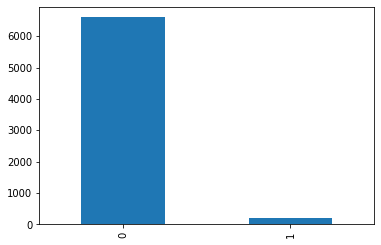

In [149]:
final_company_df['Bankrupt?'].value_counts().plot(kind = 'bar')

Dependent Variable has high class imbalance in the data.

In [150]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## <h2> Anomaly Detection

In [164]:
# *Train and Test Split of the Dataset:-*

from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(X1,Y1,test_size=0.20, random_state=0, stratify=Y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# x_train_norm = scaler.fit_transform(x_train)
x_train_norm = scaler.fit_transform(train_X)
x_test_norm = scaler.transform(test_X)


In [165]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest


In [166]:
# *Converting Dataset using StandardScalar:-*

# *Building Isolation Forest Model in UnSupervised Setting:-*

clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=0, verbose=0, contamination=0.033)
clf.fit(x_train_norm)

#Train Prediction
pred_train = clf.predict(x_train_norm)
print('accuracy score = ',accuracy_score(train_y,pred_train))
np.unique(pred_train, return_counts=True)
# target_names = ['bankrupt_company', 'normal_company']
print(classification_report(train_y, pred_train))
print ("AUC: ", "{:.1%}".format(roc_auc_score(train_y, pred_train)))
cm = confusion_matrix(train_y, pred_train )

#Test Prediction
pred_test = clf.predict(x_test_norm)
print('accuracy score = ',accuracy_score(test_y,pred_test))
print(classification_report(test_y, pred_test))
print ("AUC: ", "{:.1%}".format(roc_auc_score(test_y, pred_test)))
cm2 = confusion_matrix(test_y, pred_test)


accuracy score =  0.02933088909257562
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      5279
           1       0.03      0.91      0.06       176

    accuracy                           0.03      5455
   macro avg       0.01      0.30      0.02      5455
weighted avg       0.00      0.03      0.00      5455

AUC:  47.0%
accuracy score =  0.026392961876832845
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1320
           1       0.03      0.82      0.05        44

    accuracy                           0.03      1364
   macro avg       0.01      0.27      0.02      1364
weighted avg       0.00      0.03      0.00      1364

AUC:  42.4%


##<h2> Model Building

In [ ]:
# metric_report = pd.DataFrame(columns = ['logistic_regression','random_forest','SVM','gaussian_naive_bayes','KNN','XGBOOST'], index = ['test_acc','train_acc','test_precision','train_precision','test_recall','train_recall','test_f1-score','train_f1-score','test_auc','train_auc'])

In [ ]:
'''
#Generating Evaluation Matrix
def metricCalc(y_acc_test,y_acc_train,y_predicts_test,y_predicts_train,classifier_name,y_test_prob ,y_train_prob):

  train_accuracy = accuracy_score(y_acc_train,y_predicts_train)
  test_accuracy = accuracy_score(y_acc_test,y_predicts_test)

  train_cm = confusion_matrix(y_acc_train,y_predicts_train)
  test_cm = confusion_matrix(y_acc_test,y_predicts_test )

  prec_train = train_cm[1][1]/(train_cm[1][1] + train_cm[0][1])
  prec_test = test_cm[1][1]/(test_cm[1][1] + test_cm[0][1])

  recall_train = train_cm[1][1]/(train_cm[1][0] + train_cm[1][1])
  recall_test = test_cm[1][1]/(test_cm[1][0] + test_cm[1][1])

  f1_train = (2*prec_train*recall_train)/(recall_train + prec_train)
  f1_test = (2*prec_test*recall_test)/(recall_test + prec_test)

  auc_train = roc_auc_score(y_acc_train,y_train_prob)
  auc_test = roc_auc_score(y_acc_test,y_test_prob)

  eval_list = [test_accuracy,train_accuracy,prec_test,prec_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train]
  
  metric_report[classifier_name] = eval_list

'''

In [ ]:
'''
def modelGridSearchParams():

  # a dict that stores the params of the best models
  best_models = {}

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # grid search for Logistic Regression
  model = LogisticRegression(class_weight='balanced',C=0.01)
  solvers = ['lbfgs']
  penalty = ['l2']
  c_values = [100, 10, 1.0, 0.1, 0.01]


  # grid search
  grid = dict(solver = solvers,penalty=penalty,C=c_values)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
  grid_result = grid_search.fit(x_train_norm, train_y)

  best_models['lr_model'] = grid_result.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # Random Forest

  # Number of trees
  n_estimators = [100,250]
  # Maximum depth of trees
  max_depth = [4,6,8]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}

  rf_model = RandomForestClassifier(class_weight='balanced')

  # Grid search
  rf_grid = GridSearchCV(estimator=rf_model,
                        param_grid = param_dict,
                        cv = 5, verbose=2, scoring='roc_auc')

  rf_grid.fit(x_train_norm,train_y)

  best_models['rf_model'] = rf_grid.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # SVM
  svm_clf = SVC(probability=True, kernel='linear',class_weight='balanced')
  svm_clf.fit(x_train_norm,train_y)
  # comment in case of error
  parameters = {'C':np.linspace(0.1,0.01,1), 'gamma':('scale','auto')}
  clf_grid = GridSearchCV(estimator = svm_clf, param_grid = parameters)
  #till here
  best_models['svm_model'] = clf_grid

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # XGBoost
  # Number of trees
  n_estimators = [50,80,100,250]
  # Maximum depth of trees
  max_depth = [4,6,8,12]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}
  clf_xgb = XGBClassifier(scale_pos_weight=102)

# random search
  xg_grid = RandomizedSearchCV(clf_xgb,param_dict,cv = 5, verbose=2, scoring='roc_auc')
  xg_grid.fit(x_train_norm,train_y)

  best_models['xgb_model'] = xg_grid.best_estimator_

  return best_models
'''

In [ ]:
'''
def model_result(train_X,test_X,train_y,test_y):

  # get the best models after grid search
  best_models = modelGridSearchParams()

  # |||----------------------------------------------------------------------------------------------------------------------||| #

  # Logistic Regression:

  lr_class_train_pred = best_models['lr_model'].predict(train_X)
  lr_class_test_pred = best_models['lr_model'].predict(test_X)

  lr_prob_train_pred = best_models['lr_model'].predict_proba(train_X)[:,1]
  lr_prob_test_pred = best_models['lr_model'].predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Random Forest

  rf_class_train_pred = best_models['rf_model'].predict(train_X)
  rf_class_test_pred = best_models['rf_model'].predict(test_X)

  rf_prob_train_pred = best_models['rf_model'].predict_proba(train_X)[:,1]
  rf_prob_test_pred = best_models['rf_model'].predict_proba(test_X)[:,1]

# |||----------------------------------------------------------------------------------------------------------------------||| #

  # SVM
  svm_clf = best_models['svm_model'].fit(train_X,train_y)

  svm_class_train_pred = svm_clf.predict(train_X)
  svm_class_test_pred = svm_clf.predict(test_X)

  svm_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  svm_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Naive Bayes
  nbc = GaussianNB().fit(train_X, train_y)
  nbc_class_train_pred = nbc.predict(train_X)
  nbc_class_test_pred = nbc.predict(test_X)
  nbc_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  nbc_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # KNN
  knn = KNeighborsClassifier(n_neighbors=2,weights='uniform').fit(train_X,train_y)
  knn_class_train_pred = knn.predict(train_X)
  knn_class_test_pred = knn.predict(test_X)

  knn_prob_train_pred = knn.predict_proba(train_X)[:,1]
  knn_prob_test_pred = knn.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

# XGB
  xg_class_train_pred = best_models['xgb_model'].predict(train_X)
  xg_class_test_pred =  best_models['xgb_model'].predict(test_X)

  xg_prob_train_pred =  best_models['xgb_model'].predict_proba(train_X)[:,1]
  xg_prob_test_pred =  best_models['xgb_model'].predict_proba(test_X)[:,1]


# Calculating the scores of all the models
  metricCalc(test_y,train_y,lr_class_test_pred,lr_class_train_pred,'logistic_regression',lr_prob_test_pred,lr_prob_train_pred)
  metricCalc(test_y,train_y,rf_class_test_pred,rf_class_train_pred,'random_forest',rf_prob_test_pred,rf_prob_train_pred)
  metricCalc(test_y,train_y,svm_class_test_pred,svm_class_train_pred,'SVM',svm_prob_test_pred,svm_prob_train_pred)
  metricCalc(test_y,train_y,nbc_class_test_pred,nbc_class_train_pred,'gaussian_naive_bayes',nbc_prob_test_pred,nbc_prob_train_pred)
  metricCalc(test_y,train_y,knn_class_test_pred,knn_class_train_pred,'KNN',knn_prob_test_pred,knn_prob_train_pred)
  metricCalc(test_y,train_y,xg_class_test_pred,xg_class_train_pred,'XGBOOST',xg_prob_test_pred,xg_prob_train_pred)

  # report
  return metric_report
'''

In [154]:
model_result(x_train_norm,x_test_norm,train_y,test_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   0.6s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   0.7s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   0.7s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   0.7s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   0.7s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.5s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.5s
[CV] n_estimators=50, min_samples_split=1

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


,logistic_regression,random_forest,SVM,gaussian_naive_bayes,KNN,XGBOOST
test_acc,0.837243,0.901026,0.835044,0.803519,0.965543,0.916422
train_acc,0.849863,0.913107,0.841613,0.814115,0.975435,0.956920
test_precision,0.149606,0.206452,0.147860,0.126667,0.200000,0.226562
train_precision,0.163351,0.257329,0.157371,0.133741,1.000000,0.428224
test_recall,0.863636,0.727273,0.863636,0.863636,0.022727,0.659091
train_recall,0.886364,0.897727,0.897727,0.869318,0.238636,1.000000
test_f1-score,0.255034,0.321608,0.252492,0.220930,0.040816,0.337209
train_f1-score,0.275862,0.400000,0.267797,0.231818,0.385321,0.599659
test_auc,0.911725,0.933041,0.913791,0.913791,0.697486,0.915065
train_auc,0.937248,0.969254,0.934012,0.934012,0.992861,0.998550


## Using SMOTE-ENN for oversampling and undersampling

In [167]:
from imblearn.combine import SMOTEENN
smote_sample = SMOTEENN(random_state=0)

In [168]:
X_smote, y_smote = smote_sample.fit_resample(x_train_norm, train_y)

In [169]:
X_smote.shape

(9996, 23)

In [170]:
y_smote.shape

(9996,)

Using Tomek Links to create pairs of opposing instances that are very close together.

In [175]:
from imblearn.under_sampling import TomekLinks
tomek_links = TomekLinks(random_state=0,ratio='majority')
X_after_tomek, y_after_tomek = tomek_links.fit_sample(X_smote, y_smote)

In [172]:
X_after_tomek.shape

(9996, 23)

In [173]:
y_after_tomek.shape

(9996,)

**Tomek Links is of no use as the shape of X and Y remains same.**

Model Testing after Using Smote-ENN

In [174]:
model_result(X_after_tomek,x_test_norm,y_after_tomek,test_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=40, max_depth=8, total=   0.8s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   1.0s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=6 
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=50, max_depth=6, total=   1.0s
[CV] n_estimators=80, min_samples_split=1

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


,logistic_regression,random_forest,SVM,gaussian_naive_bayes,KNN,XGBOOST
test_acc,0.837243,0.909091,0.833578,0.771261,0.911290,0.950147
train_acc,0.910064,0.908263,0.920968,0.879752,1.000000,0.919968
test_precision,0.149606,0.222222,0.141176,0.112717,0.218978,0.300000
train_precision,0.918540,0.966058,0.920211,0.863783,1.000000,1.000000
test_recall,0.863636,0.727273,0.818182,0.886364,0.681818,0.409091
train_recall,0.909627,0.855594,0.930365,0.915715,1.000000,0.847793
test_f1-score,0.255034,0.340426,0.240803,0.200000,0.331492,0.346154
train_f1-score,0.914062,0.907477,0.925260,0.888992,1.000000,0.917628
test_auc,0.911725,0.933006,0.908798,0.908798,0.794473,0.906973
train_auc,0.971560,0.985055,0.971248,0.971248,1.000000,0.996914


**<h2>Conclusion**

1. Initially built base models (without feature selection and sampling) had high accuracy values but all other metrics like recall and f1 score were very low.
2. If Accuracy is critical to the use case, then KNN model should be feature selection, to obtain a 96.6% Accuracy score.
3. If Recall is critical to the use case, then Gaussian Naive Bayes model should be  used with feature selection and SMOTEENN, to obtain a 88.6% Recall value.

4. If over-all performance is critical to the use case, then KNN  Model with, feature selection(RandomForest & Isolation forest) and SMOTE ENN can be used  to obtain F1 score of 33%.


<h2> Pipleline.

In [178]:
# Inference code.
# from imblearn.pipeline import make_pipeline
# o_step = np.linspace(0.1,1,20)

# pipe_line = make_pipeline(
#     SMOTEENN(),
#     TomekLinks(),
#     XGBClassifier()
# )

# gridcv = GridSearchCV(
#     estimator=pipe_line,
#     param_grid={
#         'smoteenn__sampling_strategy':o_step,
#         'tomeklinks__sampling_strategy':o_step    },
#     scoring='f1',
#     cv=4
# )

# output = gridcv.fit(X_after_tomek,y_after_tomek)

**<h1>THANK YOU**
